# Previously we have considered how to work with Time Series data by ARIMA and ML techniques
# Here and now we are going to find connections and create approach to predict Q2 values depending on pumps, sprinkles and HE fouling effects

In [468]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels

In [469]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import (
    TimeSeriesSplit, cross_validate, 
    KFold, train_test_split,
    ShuffleSplit
)
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree

from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from joblib import dump, load

In [470]:
# fc 119,120,121
fcs = [
    ("2021-03-09", "2021-04-12"), ("2021-04-12", "2021-05-11"), ("2021-05-11", "2021-09-20")
]

### All IDs used
* 299 Т1к после ТО
* 309 Р2контура
* 315 T1k before HE
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 321 T reactor
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 480 Q1k
* 481 Q2контура
#### Second loop I pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [471]:
sys.path.insert(0, os.path.split(os.path.abspath(""))[0])
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))

In [472]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates
from statistics import Statistics as st
from data_engineering import PeriodicDataPreprocess, FeatureEngineering
from statistics import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima import model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [473]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, ccf

In [474]:
# df = pd.read_excel("rdy_for_fe_121020_to_210423.xlsx", index_col="Timestamp")
# df_nosma = pd.read_excel("rdy_for_fe_121020_to_210423_no_sma.xlsx", index_col="Timestamp")



In [1152]:
# 5 min frequency

df_stats = pd.read_excel("!important_input_files/rdy_for_stats_121020_080923_1h_freq.xlsx", index_col="Timestamp")

In [1153]:
df_stats["HE4_TOP"]

Timestamp
2020-10-13 00:00:00     8.514286
2020-10-13 13:00:00    17.028571
2020-10-13 14:00:00    25.542857
2020-10-13 15:00:00    34.057143
2020-10-13 16:00:00    42.571429
                         ...    
2023-09-06 14:00:00     0.000000
2023-09-06 15:00:00     0.000000
2023-09-06 16:00:00     0.000000
2023-09-06 17:00:00     0.000000
2023-09-06 18:00:00     0.000000
Name: HE4_TOP, Length: 5852, dtype: float64

<AxesSubplot: xlabel='QbyIP', ylabel='Count'>

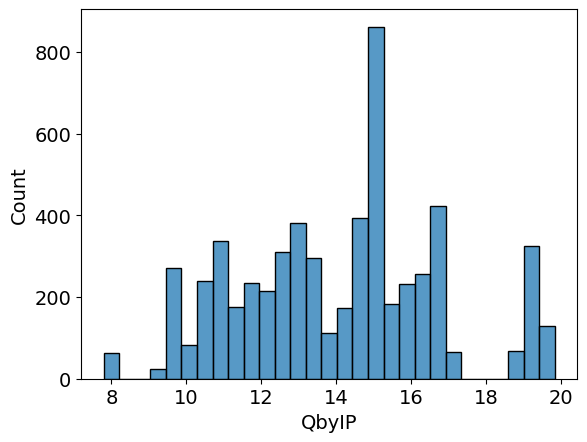

In [1154]:
sns.histplot(df_stats["QbyIP"])

<AxesSubplot: xlabel='Q2', ylabel='Count'>

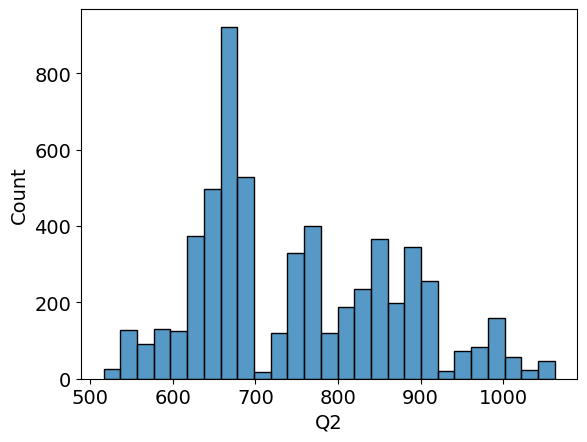

In [1155]:
sns.histplot(df_stats["Q2"])

In [1156]:
from statsmodels.api import qqplot

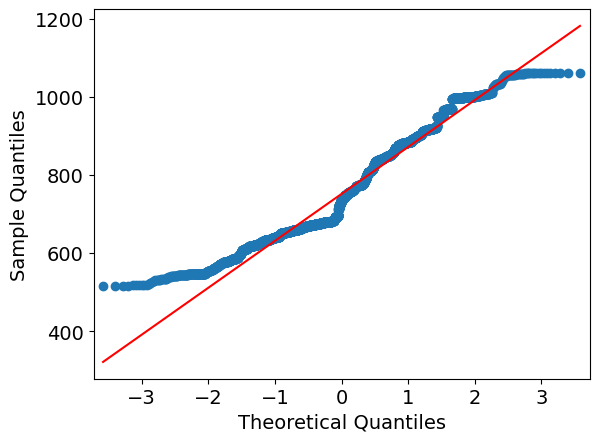

In [1157]:
qqplot(df_stats["Q2"].to_numpy(), line ='s')
plt.show()

In [1158]:
df_stats_gr = df_stats.groupby(pd.Grouper(freq="2h")).mean()

Timestamp
2020-10-13 00:00:00    651.812917
2020-10-13 12:00:00    652.146667
2020-10-13 14:00:00    652.204792
2020-10-13 16:00:00    651.961875
2020-10-13 18:00:00    652.137917
                          ...    
2023-06-09 00:00:00    809.384792
2023-06-09 02:00:00    808.175417
2023-06-09 04:00:00    806.845208
2023-06-09 06:00:00    805.513958
2023-06-09 08:00:00    804.670000
Name: Q2, Length: 1703, dtype: float64


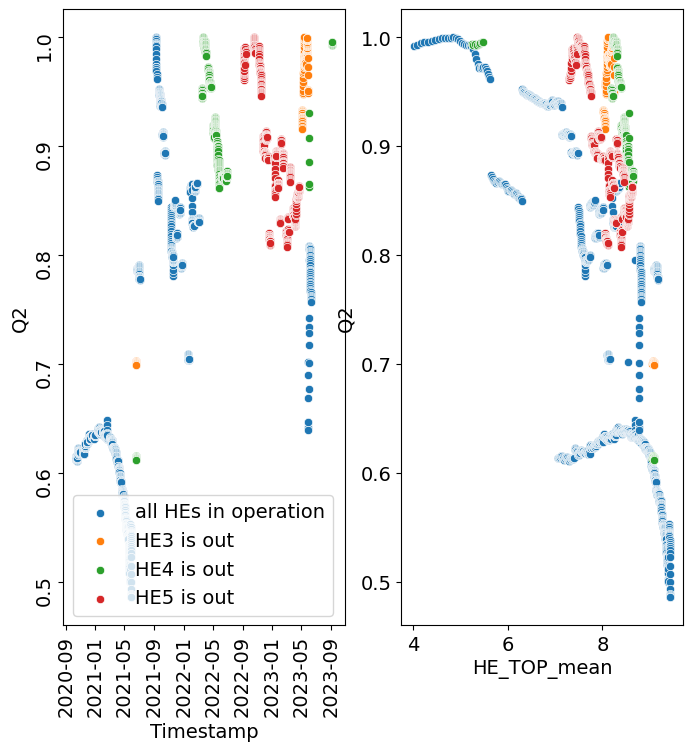

In [1159]:

fig, axs = plt.subplots(1,2, figsize=(8,8))

qbyip = df_stats_gr["Q2"]

qbyip_all = qbyip[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
].dropna(axis=0)
qbyip3 = qbyip[df_stats_gr["HE3_status"] == 0].dropna(axis=0)
qbyip4 = qbyip[df_stats_gr["HE4_status"] == 0].dropna(axis=0)
qbyip5 = qbyip[df_stats_gr["HE5_status"] == 0].dropna(axis=0)

print(qbyip_all)

hetop_all = df_stats_gr[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
]["HE_TOP_mean"].dropna(axis=0)
hetop3 = df_stats_gr[df_stats_gr["HE3_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop4 = df_stats_gr[df_stats_gr["HE4_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop5 = df_stats_gr[df_stats_gr["HE5_status"] == 0]["HE_TOP_mean"].dropna(axis=0)


sns.scatterplot(qbyip_all / qbyip_all.max(), ax=axs[0], label="all HEs in operation")
sns.scatterplot(qbyip3 / qbyip3.max(), ax=axs[0], label="HE3 is out")
sns.scatterplot(qbyip4 / qbyip4.max(), ax=axs[0], label="HE4 is out")
sns.scatterplot(qbyip5 / qbyip5.max(), ax=axs[0], label="HE5 is out")
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].max(), ax=axs[0])

sns.scatterplot(x=np.log(hetop_all), y=qbyip_all / qbyip_all.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop3), y=qbyip3 / qbyip3.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop4), y=qbyip4 / qbyip4.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop5), y=qbyip5 / qbyip5.max(), ax=axs[1])

axs[0].tick_params(rotation=90)
# sns.scatterplot(qbyip / df_stats.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1))

# On a first look, all curves have similar trends and no matter what HEs are in operation
# However, the cycles that starts from 0 (HE_TOP_mean) have 2 different trends
# It's quite obvious that each cycle is non-stationry around QbyIP

# I assume that data of winter of 2021 is not clear cuz Tair is hardly reach -5
# However usually it dropsbelow -20 -> absolutly anomaly data
## Data till april of 2021 has dropped

In [1160]:
# df_stats = df_stats.loc["2021-04":, :]
df_stats.shape

(5852, 39)

In [1161]:
df_stats["HEs_num"] = df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)
df_stats["Q2_HEs_num"] = df_stats["Q2"] / df_stats["HEs_num"]
df_stats["QbyIP_HEs_num"] = df_stats["QbyIP"] / df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)


In [1162]:
df_stats.columns

Index(['CTF1', 'CTF2', 'CTF3', 'P2', 'Q2', 'T1aHE', 'T1bHE', 'T2aHE', 'T2aHE1',
       'T2aHE2', 'T2aHE3', 'T2aHE4', 'T2aHE5', 'T2bHE', 'Tair', 'Treactor',
       'p21', 'p22', 'p23', 'p24', 'dt1', 'dt2', 'pumps2', 'dt_circuits_coef',
       'dt_circuits_coef_delta', 'I2mean', 'QbyIP', 'HE1_TOP', 'HE2_TOP',
       'HE3_TOP', 'HE4_TOP', 'HE5_TOP', 'HE1_status', 'HE2_status',
       'HE3_status', 'HE4_status', 'HE5_status', 'HE_TOP_mean', 'CTF_sum',
       'HEs_num', 'Q2_HEs_num', 'QbyIP_HEs_num'],
      dtype='object')

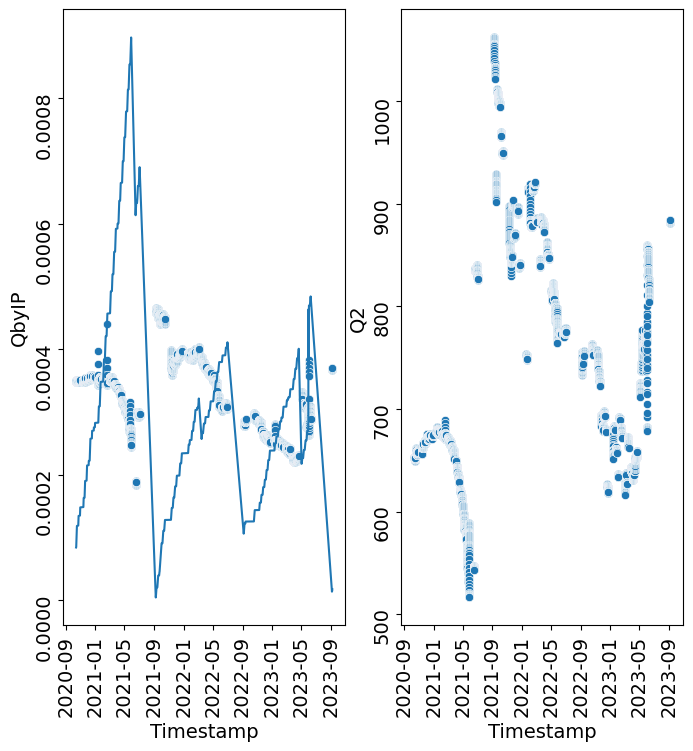

In [1163]:
fig, axs = plt.subplots(1,2, figsize=(8,8))
sns.scatterplot(df_stats["QbyIP"]/df_stats_gr["QbyIP"].sum(), ax=axs[0])
sns.lineplot(df_stats["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

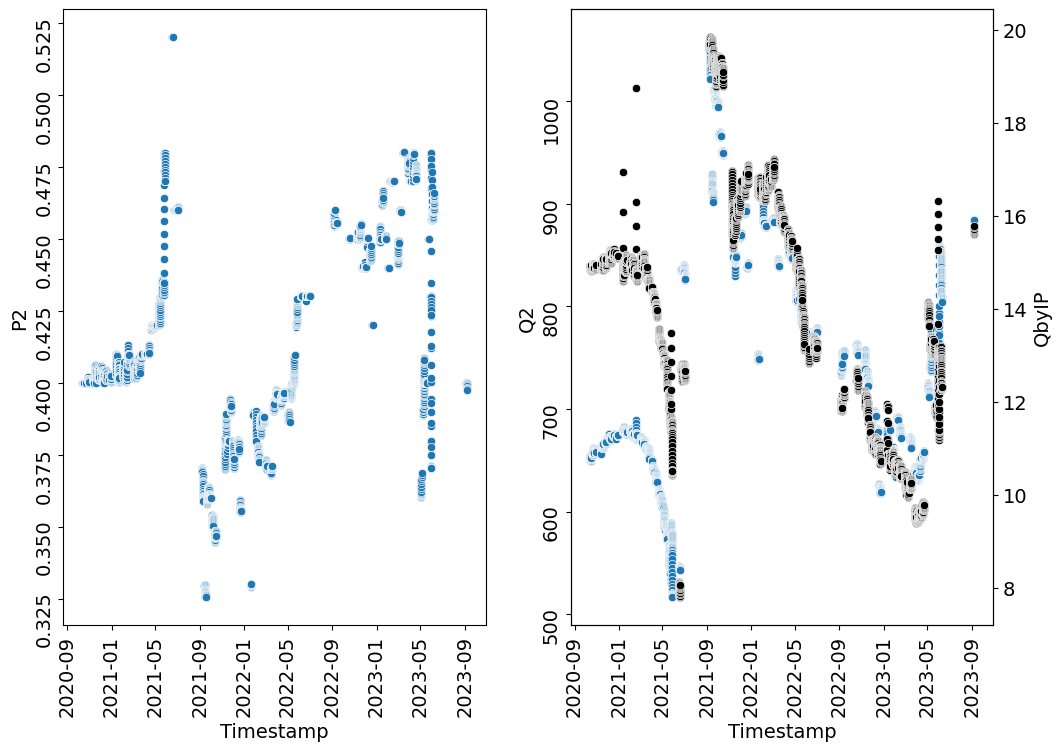

In [1164]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
sns.scatterplot(df_stats["P2"], ax=axs[0])
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])
axs11 = axs[1].twinx()
sns.scatterplot(df_stats["QbyIP"], color="black", ax=axs11)
axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

# From diary of maintenance of reactor systems i've learned that nozzles where cleaned only at summer of 2020, 2021. So they status must be taken into account

In [1165]:
fe = FeatureEngineering(df_stats)

In [1166]:
# nozzles_periods = [
#     ("2020-10-12", "2021-07-02"), 
#     ("2021-09-06", "2023-06-09"),
# #     ("2023-09-05", "2023-09-08")
# ]

nozzles_periods = [
    ("2021-09-06", "2023-06-09"),
#     ("2023-09-05", "2023-09-08")
]

df_stats = fe.make_time_onpower_feature(
    time_periods=nozzles_periods,
    feature_name="Nozzles_TOP",
    start=[0,0]
)

[3.90754382e+00 7.81508763e+00 1.17226314e+01 ... 1.53761849e+04
 1.53800925e+04 1.53840000e+04] 3937 3937


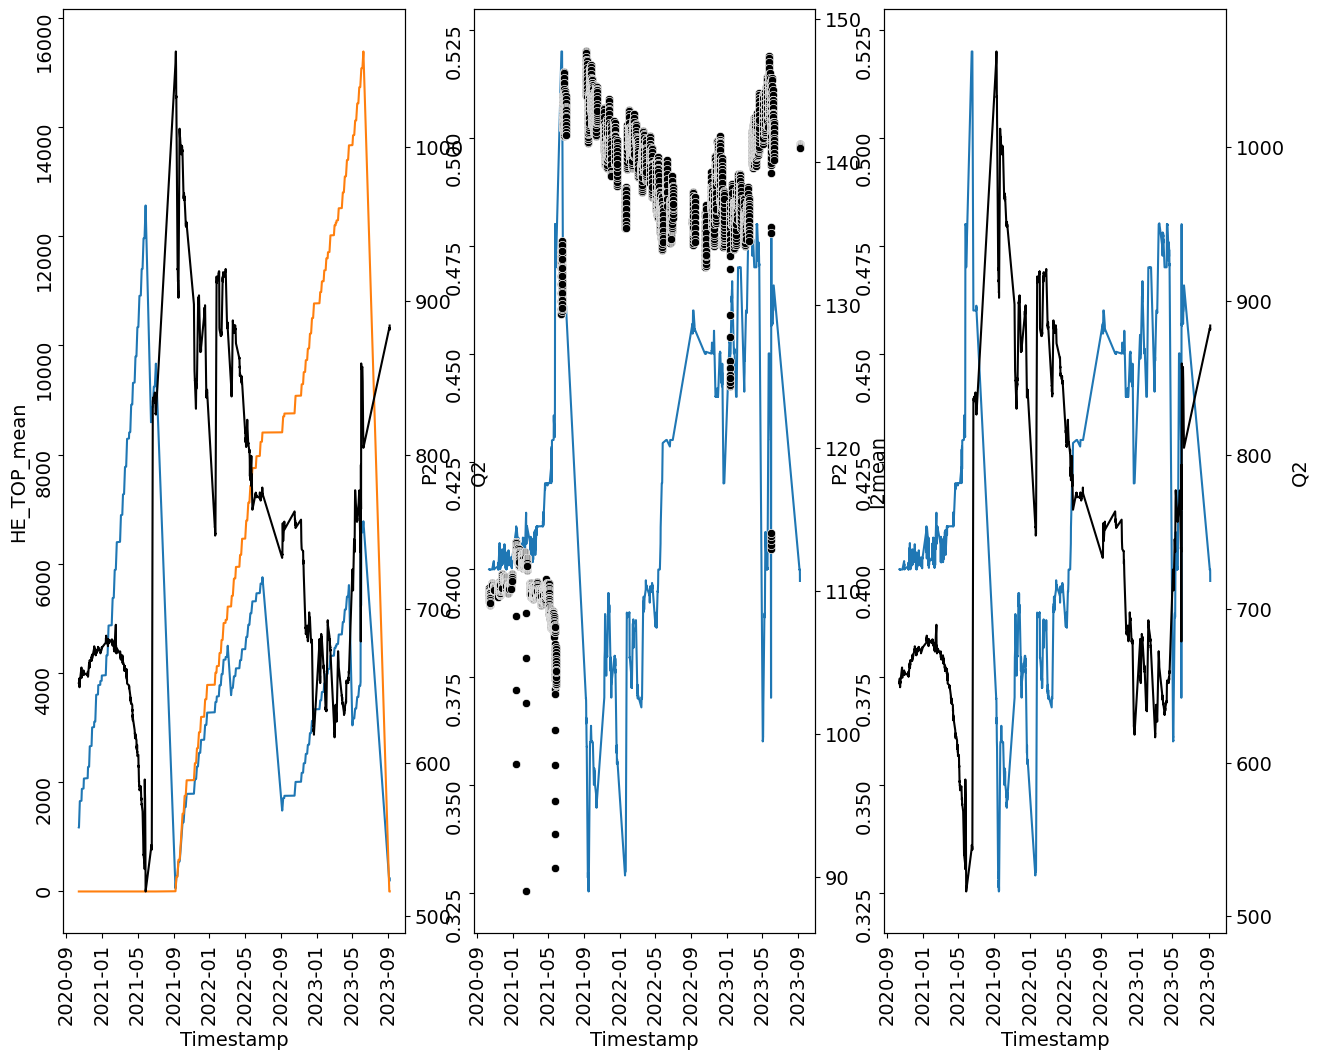

In [1167]:
fig, axs = plt.subplots(1,3, figsize=(15,12))
ax0 = axs[0].twinx()
sns.lineplot(df_stats["Q2"], color="black", ax=ax0)
sns.lineplot(df_stats["HE_TOP_mean"], ax=axs[0])
sns.lineplot(df_stats["Nozzles_TOP"], ax=axs[0])

ax1 = axs[1].twinx()
sns.lineplot(df_stats["P2"], ax=axs[1])
sns.scatterplot(df_stats["I2mean"], color="black", ax=ax1)

ax2 = axs[2].twinx()
sns.lineplot(df_stats["P2"], ax=axs[2])
sns.lineplot(df_stats["Q2"], color="black", ax=ax2)

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)
axs[2].tick_params(rotation=90)

In [1168]:
df_stats["pumps2"].value_counts()

234     4255
123      613
134      579
124      322
1234      83
Name: pumps2, dtype: int64

<AxesSubplot: ylabel='QbyIP'>

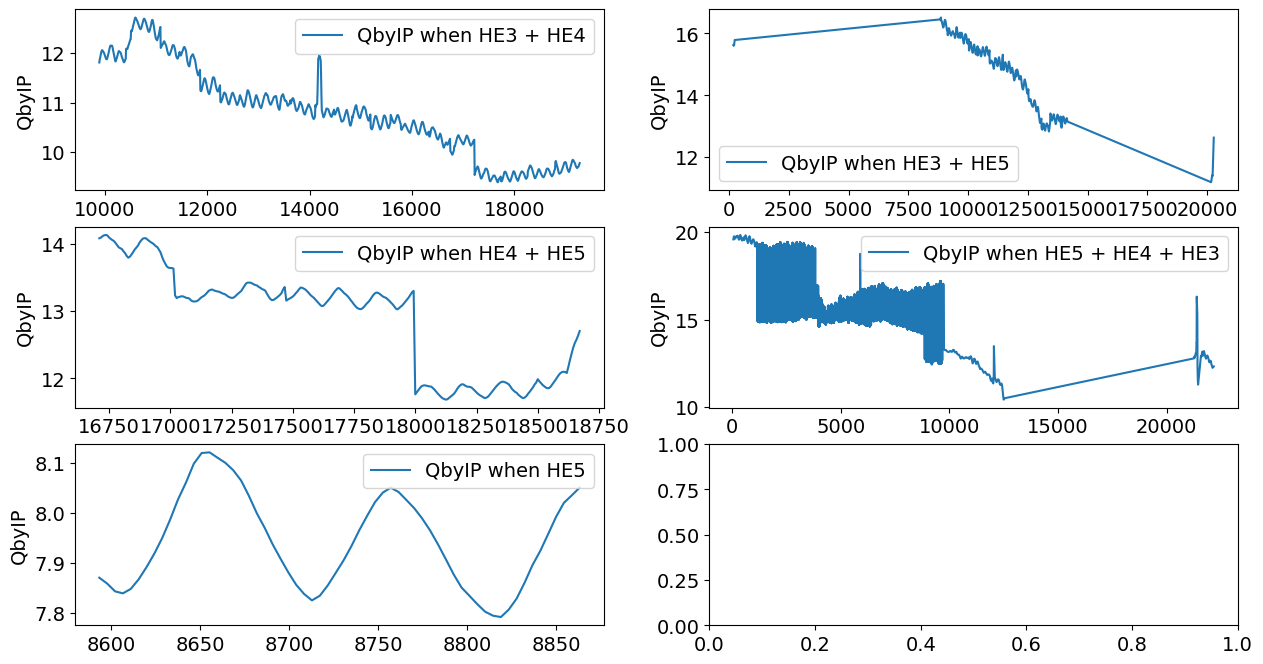

In [1169]:
fig, axs = plt.subplots(3,2, figsize=(15,8))
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
#     y=df_stats["QbyIP"],
#     ax=axs[0][0],
#     label="Bare QbyIP"
# )
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5"
)


# As we can see from dependencies above:
## Strong dependencies from what HE operated 
# Need to consider  dependencies to operated pumps  additionally to aquired data

In [1171]:
# fig, axs = plt.subplots(3,2, figsize=(15,8))

# # axs[0][0]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#     ],
#     color="black",
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4 + pumps234"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#         & (df_stats["pumps2"] == 124)
#     ],
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4 + pumps124"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#         & (df_stats["pumps2"] == 123)
#     ],
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4 + pumps123"
# )


# # axs[0][1]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"], 
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE4_status"] == 0)
#     ],
#     color="black",
#     ax=axs[0][1],
#     label="QbyIP when HE3 + HE5"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE4_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[0][1],
#     label="QbyIP when HE3 + HE5 + pumps234"
# )


# # axs[1][0]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#     ],
#     color="black",
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5 + pumps234"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 134)
#     ],
#     color="red",
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5 + pumps134"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 123)
#     ],
#     color="red",
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5 + pumps123"
# )


# # axs[1][1]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] != 0)
#     ],
#     color="black",
#     ax=axs[1][1],
#     label="QbyIP when HE5 + HE4 + HE3"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] != 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[1][1],
#     label="QbyIP when HE5 + HE4 + HE3 + pumps234"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] != 0)
#         & (df_stats["pumps2"] == 1234)
#     ],
#     ax=axs[1][1],
#     label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
# )

 
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] == 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#     ],
#     color="black",
#     ax=axs[2][0],
#     label="QbyIP when HE5"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] == 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 134)
#     ],
#     ax=axs[2][0],
#     label="QbyIP when HE5 + pumps134"
# )


KeyError: 'y'

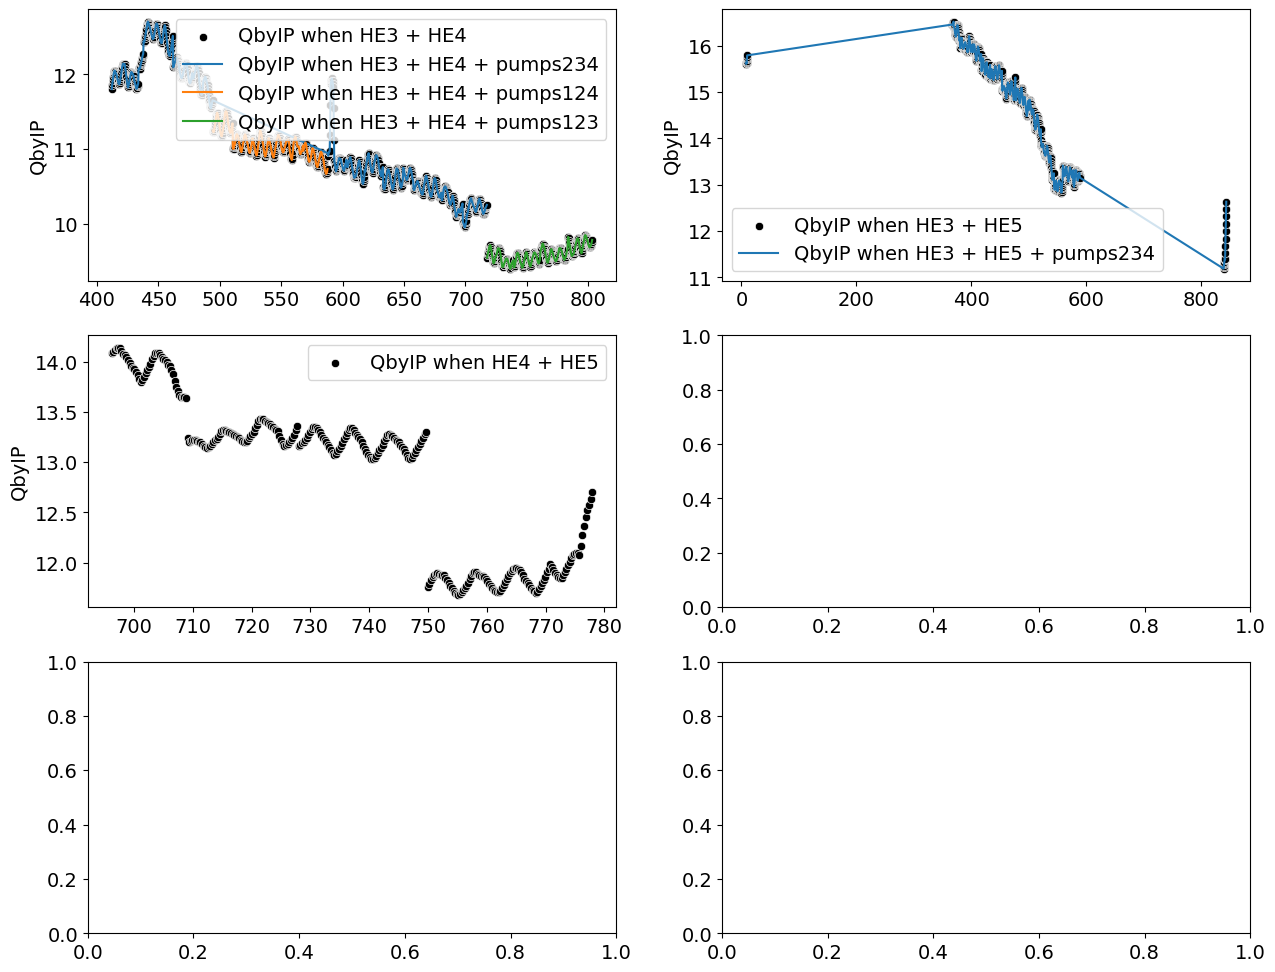

In [1172]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5 + pumps234"
)


# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps123"
)


# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="QbyIP when HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5 + pumps134"
)

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"]

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="Q2 when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="Q2 when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="Q2 when HE3 + HE5 + pumps234"
)

# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps123"
)



# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="Q2 when HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="Q2 when HE5 + pumps134"
)

In [ ]:
sns.lineplot(x=df_stats["Nozzles_TOP"], y=df_stats["Q2"])

In [ ]:
plt.rcParams.update({'font.size': 12})

sns.scatterplot(df_stats.loc[:,"Q2"], edgecolor = None)
plt.ylabel("Объемный расход $м^3$/ч")
plt.xlabel("Даты")
plt.tick_params(rotation=90)

In [ ]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н123"
)



sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н123"
)
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Объемный расход $м^3$/ч/А/МПа")
axs[1].set_xlabel("Длительность работы, эфф.суток")

Text(0.5, 0, 'Длительность работы, эфф.суток')

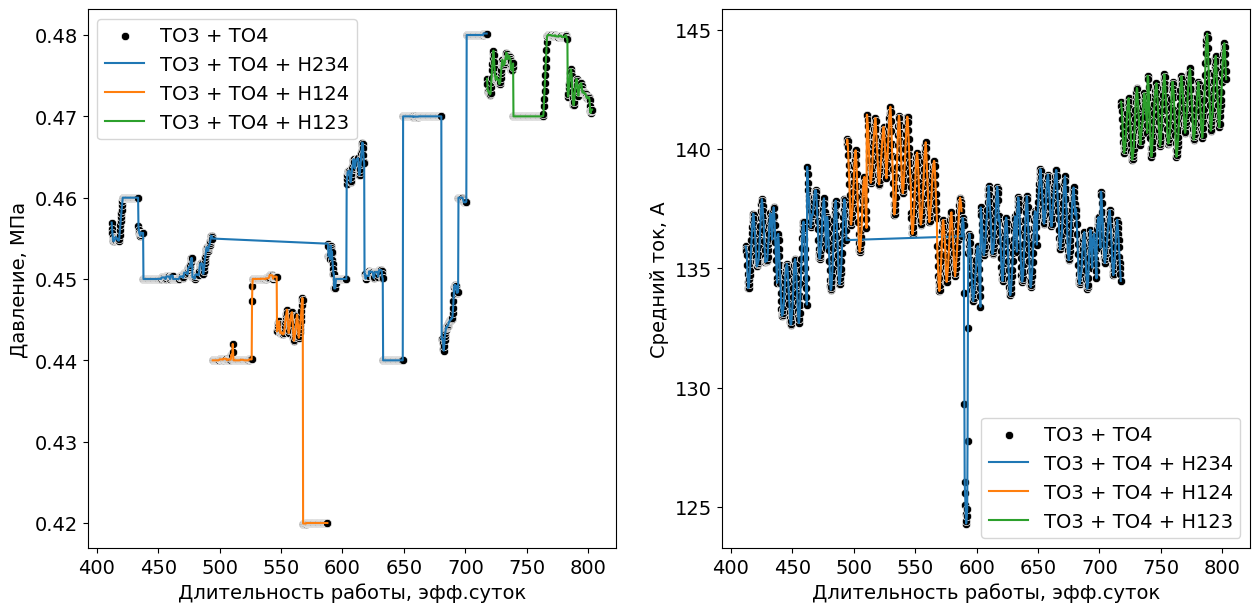

In [1173]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))
x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н123"
)


sns.scatterplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н123"
)

axs[0].set_ylabel("Давление, МПа")
axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Средний ток, А")
axs[1].set_xlabel("Длительность работы, эфф.суток")

# plt.tick_params(rotation=90)

(0.20845482253004288, 0.4144764259588731)

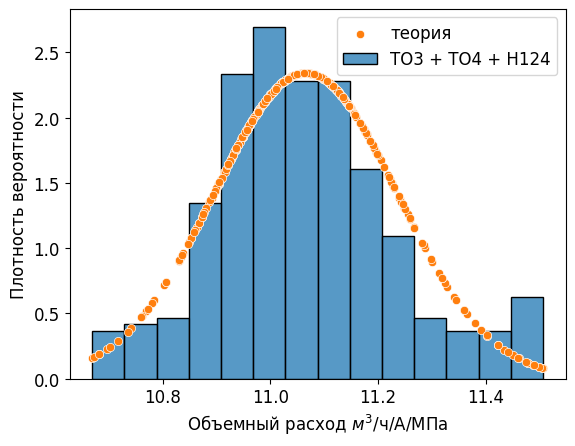

In [1174]:
plt.rcParams.update({'font.size': 12})

data = df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["QbyIP"] < 11.7)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Объемный расход $м^3$/ч/А/МПа")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

(-0.6984974765661671, -0.2755206006038699)

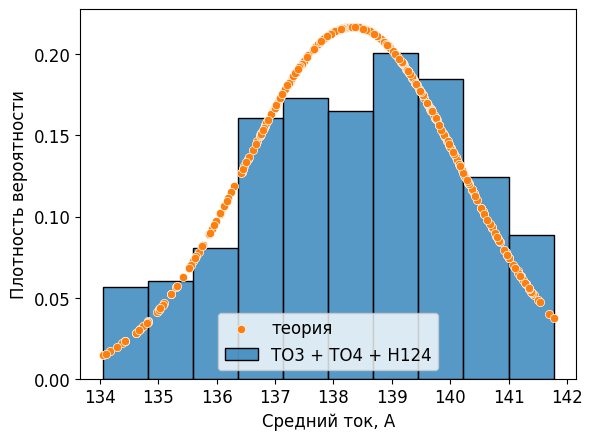

In [1175]:
plt.rcParams.update({'font.size': 12})

data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Средний ток, А")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

Text(0, 0.5, 'Вероятность')

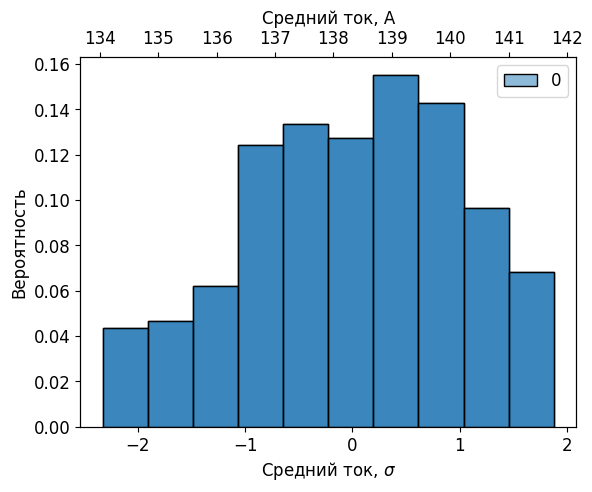

In [1176]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
ax2 = ax.twiny()
data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

data_ss = StandardScaler().fit_transform(data.to_numpy().reshape(-1,1))

sns.histplot(
    data_ss,
    stat="probability",
    ax=ax
)
sns.histplot(
    data,
    stat="probability",
    ax=ax2
)

ax2.set_xlabel("Средний ток, А")
ax.set_xlabel("Средний ток, $\sigma$")
ax.set_ylabel("Вероятность")

# After pumps status were added as important feature to describe all dependencies we may consider distribution once again

(-4.752324038201918,
 6.703491901817652e-05,
 10,
 718,
 {'1%': -3.439490435810785,
  '5%': -2.8655738086413374,
  '10%': -2.568918067209286},
 870.3584493313808)

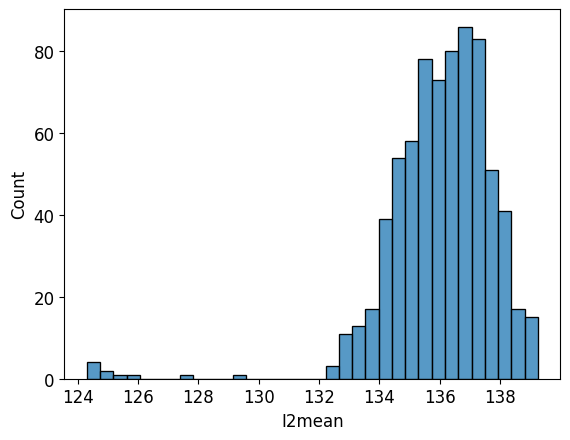

In [1177]:
df_he34_p234 = (df_stats[
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ]
    ).dropna()
sns.histplot(
    df_he34_p234["I2mean"]
)

statsmodels.tsa.stattools.adfuller(
    df_he34_p234["I2mean"]
)

<AxesSubplot: >

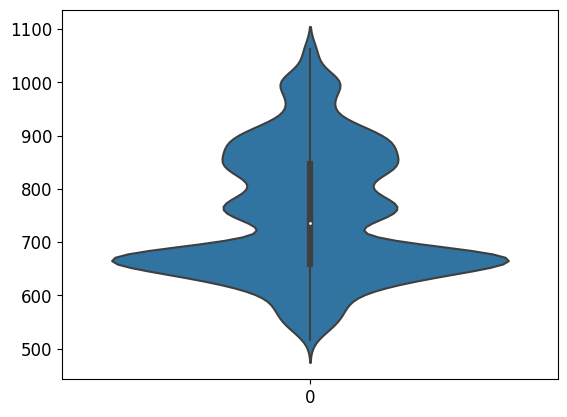

In [1178]:
sns.violinplot(df_stats["Q2"])

In [1179]:
df_stats["pumps2"].value_counts()

234     4255
123      613
134      579
124      322
1234      83
Name: pumps2, dtype: int64

In [1442]:
selection_cols_Q2 = [
    "Q2", 
    "P2", 
#     "I2mean", 
    "Nozzles_TOP", 
    "HE_TOP_mean",
#     "HE3_status",
#     "HE4_status", 
#     "HE5_status",
    "pumps2", 
#     "HEs_num"
    ]
df_stats_Q2 = df_stats.loc[
    :, 
    selection_cols_Q2
]

# df_stats_Q2 = df_stats_undersampled.loc[
#     :, 
#     [
#         "Q2", "P2", "I2mean", "Nozzles_TOP", 
#         "HE_TOP_mean","HE3_status",
#         "HE4_status", "HE5_status",
#         "pumps2",
#         "HEs_num"
#     ]
# ]

In [1443]:
df_stats_Q2["pumps2"].value_counts()

234     4255
123      613
134      579
124      322
1234      83
Name: pumps2, dtype: int64

In [1444]:
numerical_cols = [
    "Nozzles_TOP",
#     "I2mean", 
    "HE_TOP_mean"
]
ct = ColumnTransformer(
        [
            ("numerical_data", StandardScaler(), numerical_cols),
            ("categorical_data", OneHotEncoder(sparse=False), ["pumps2"])
        ],
        remainder="passthrough"
).set_output(transform="pandas")

In [1445]:
# df_stats_Q2 = pd.concat(
#     [
#         df_stats_Q2, 
#         pd.get_dummies(df_stats["pumps2"], prefix="pumps")
#     ], 
#     axis=1
# ) 

In [1446]:
df_stats_Q2_heatmap = ct.fit_transform(df_stats_Q2)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1447]:
df_stats_Q2_heatmap.columns

Index(['numerical_data__Nozzles_TOP', 'numerical_data__HE_TOP_mean',
       'categorical_data__pumps2_123', 'categorical_data__pumps2_124',
       'categorical_data__pumps2_134', 'categorical_data__pumps2_234',
       'categorical_data__pumps2_1234', 'remainder__Q2', 'remainder__P2'],
      dtype='object')

In [1448]:
names = [
    "T работы форсунок",
    "Ток насосов",
    "T работы ТО",
    "Н123",
    "Н124",
    "Н134",
    "Н234",
    "Н1234",
    "3 ТО в работе",
    "4 ТО в работе",
    "5 ТО в работе",
    "Q",
    "P",
    "ТО3",
    "ТО4",
    "ТО5"
]

mask = [
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    True,
    True,
    True
]

<AxesSubplot: >

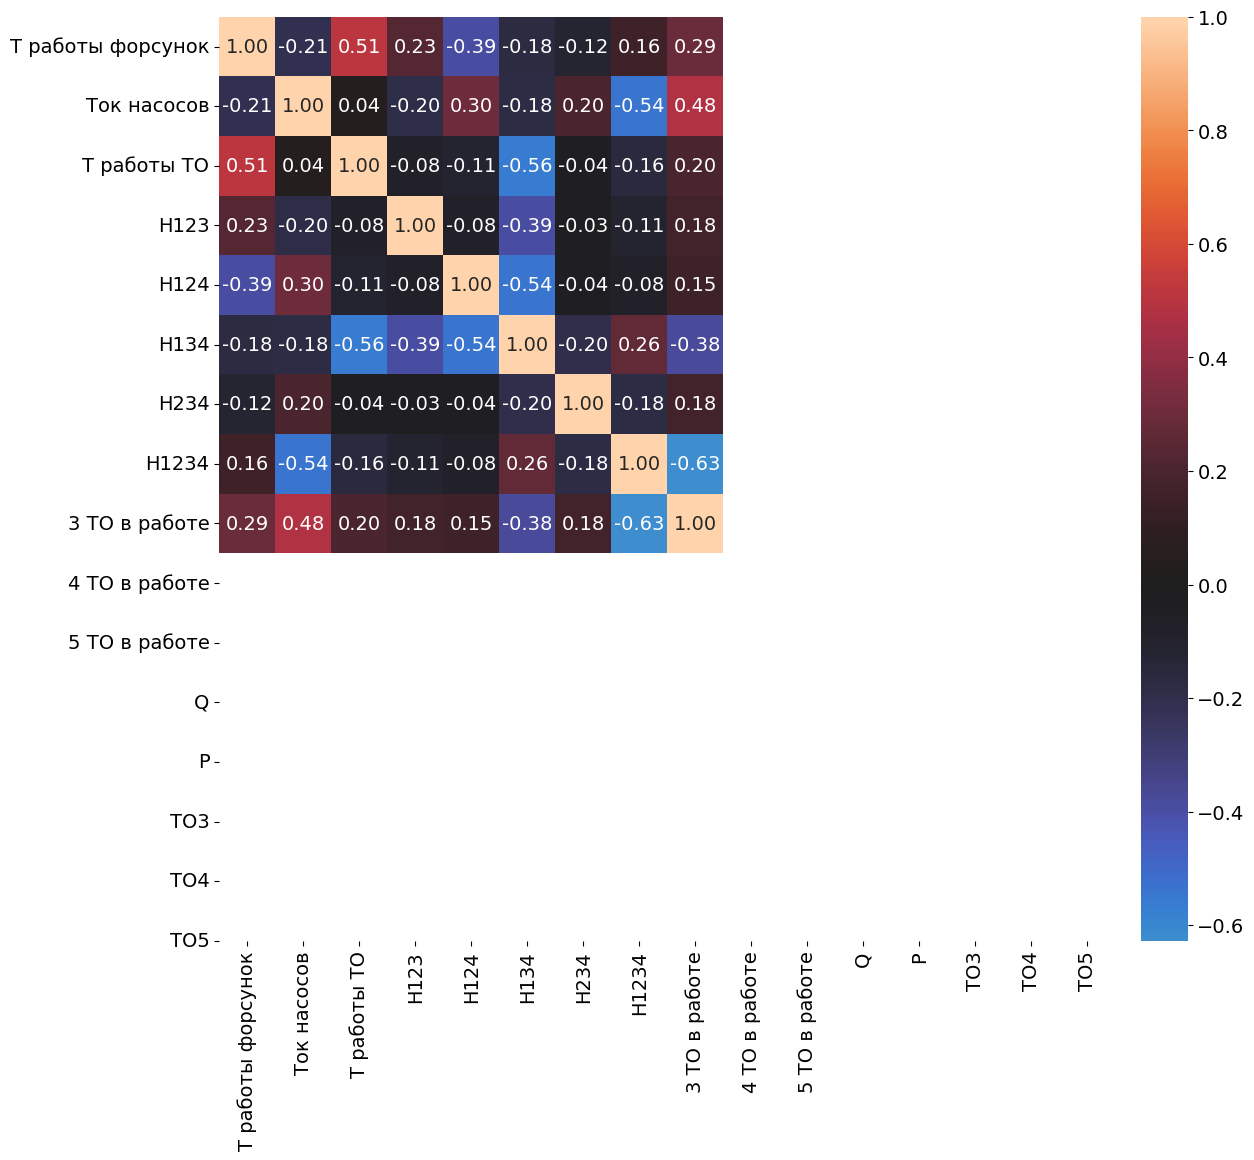

In [1449]:
plt.figure(figsize=(14,12))
sns.heatmap(
    df_stats_Q2_heatmap.corr(method='spearman'), 
    annot=True, 
    fmt=".2f", 
    xticklabels=names, 
    yticklabels=names,
    center=0,
#     mask=mask
)
# plt.xticks(rotation=45)

In [1450]:
from sklearn.multioutput import MultiOutputRegressor

In [1451]:
X = df_stats_Q2.drop(["Q2", "P2"], axis=1)
y = df_stats_Q2[["Q2", "P2"]]

In [1456]:
X.shape, y.shape

((5852, 3), (5852, 2))

In [1457]:
def evaluate(model, X, y, cv):
#     print(X)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [1458]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [1360]:
pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    GradientBoostingRegressor()
).set_output(transform="pandas")


In [1361]:
mor_pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    MultiOutputRegressor(HistGradientBoostingRegressor())
).set_output(transform="pandas")

mor_pl_1 = make_pipeline(
    ct,
    MultiOutputRegressor(KNeighborsRegressor())
).set_output(transform="pandas")

mor_pl_2 = make_pipeline(
    ct,
    MultiOutputRegressor(tree.DecisionTreeRegressor())
).set_output(transform="pandas")

In [1362]:
# multioutput
mor_gbr = mor_pl.fit(X_train, y_train)
mor_pl_1.fit(X_train, y_train)
mor_pl_2.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_data',
                                                  StandardScaler(),
                                                  ['Nozzles_TOP',
                                                   'HE_TOP_mean']),
                                                 ('categorical_data',
                                                  OneHotEncoder(sparse=False),
                                                  ['pumps2'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor()))])

1.1810663862490556
0.0005318917455837768


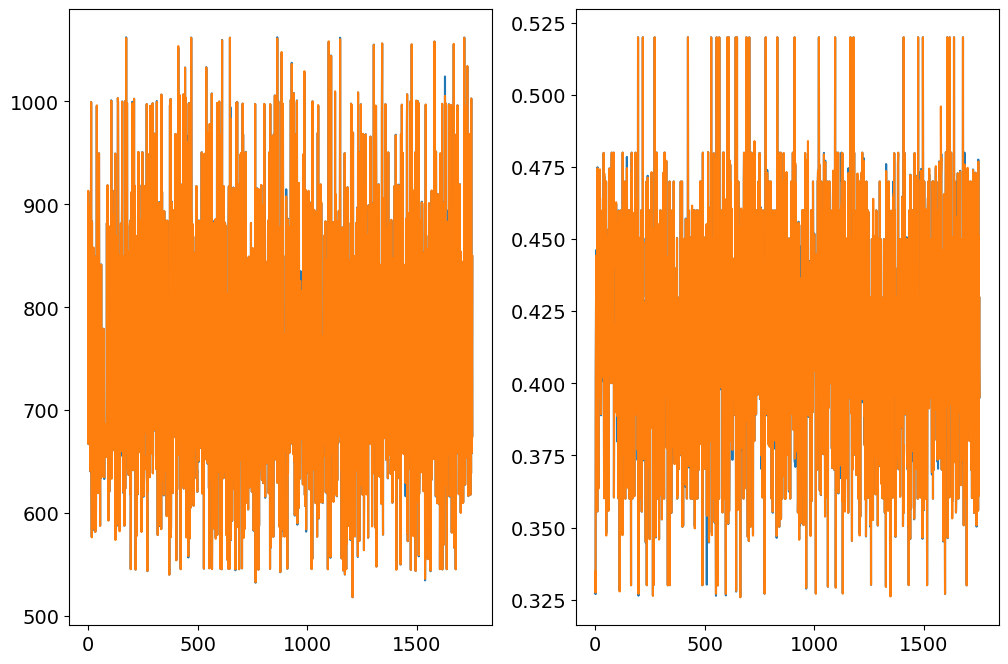

In [1363]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_1.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_1.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

1.1366006025446933
0.00040289070283973296


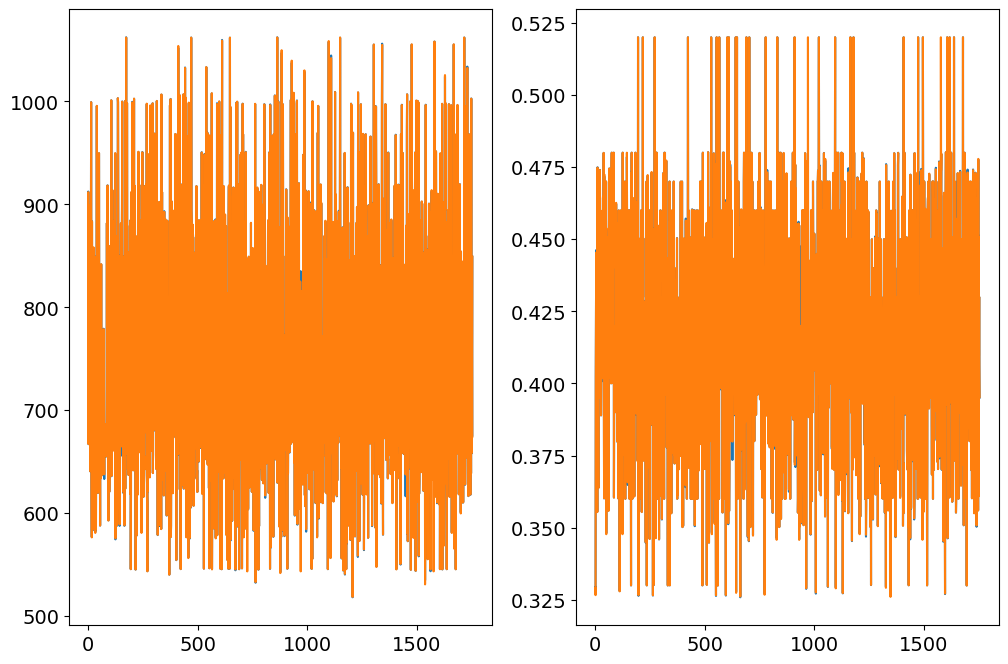

In [1364]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_2.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_2.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

3.007548141627568
0.001207558397604518


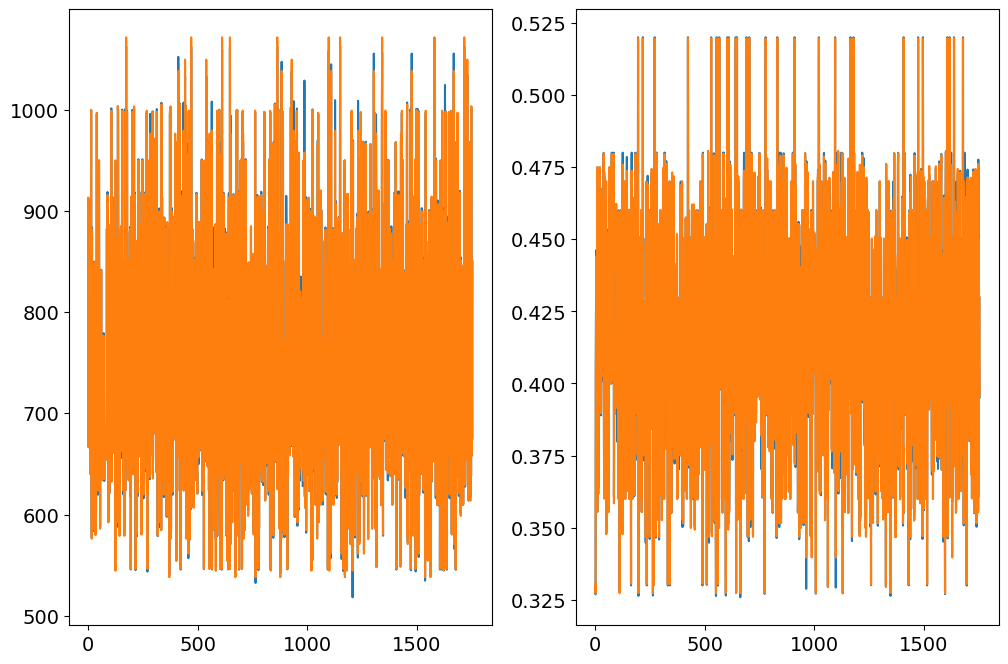

In [1365]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0],
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0],
    errorbar=("pi", 100)
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_gbr.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_gbr.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

## USE of folds to predict

In [1366]:
ss_folds = list(ShuffleSplit(n_splits=4).split(X,y))
k_folds = list(KFold(n_splits=4).split(X,y))

In [1367]:
gbr_pl1 = pl

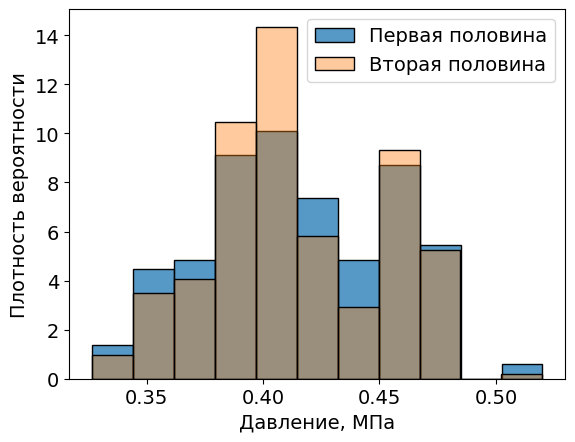

In [1368]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

<AxesSubplot: xlabel='Q2', ylabel='Count'>

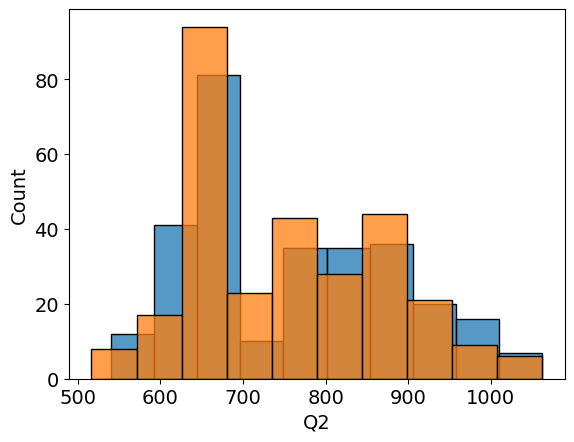

In [1369]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["Q2"]
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["Q2"]
)

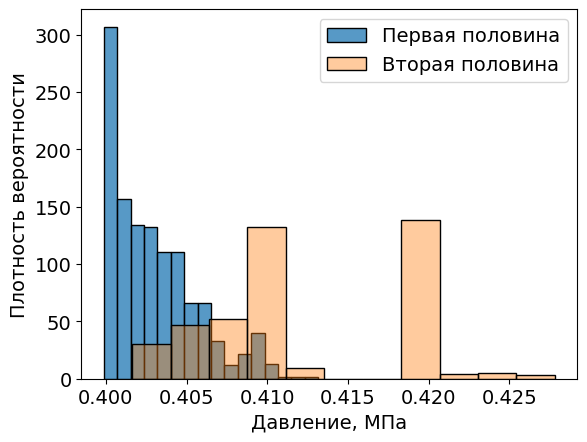

In [1370]:
sns.histplot(
    y.iloc[
        k_folds[0][1][:int(len(k_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        k_folds[0][1][int(len(k_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib

1.4575814552250652
245.80775130636363
single_pred 678.3723333333334 924.180084639697 432.56458202696973 678.26625
758.4244945576718 748.5868581387251 768.2621309766184
0.9270865093964827
29.341128435251527
single_pred 782.9400000000002 812.2811284352517 753.5988715647486 782.655
744.0123107535202 734.7676367306309 753.2569847764095
0.7893275736007807
15.627373052244467
single_pred 682.3261350579523 697.9535081101968 666.6987620057079 682.300551724619
744.4658373575494 734.7736760116702 754.1579987034286
0.8476785221022682
19.751185193244304
single_pred 850.5809999999999 870.3321851932442 830.8298148067556 850.2066666666667
751.7636938563653 741.9346559512139 761.5927317615167


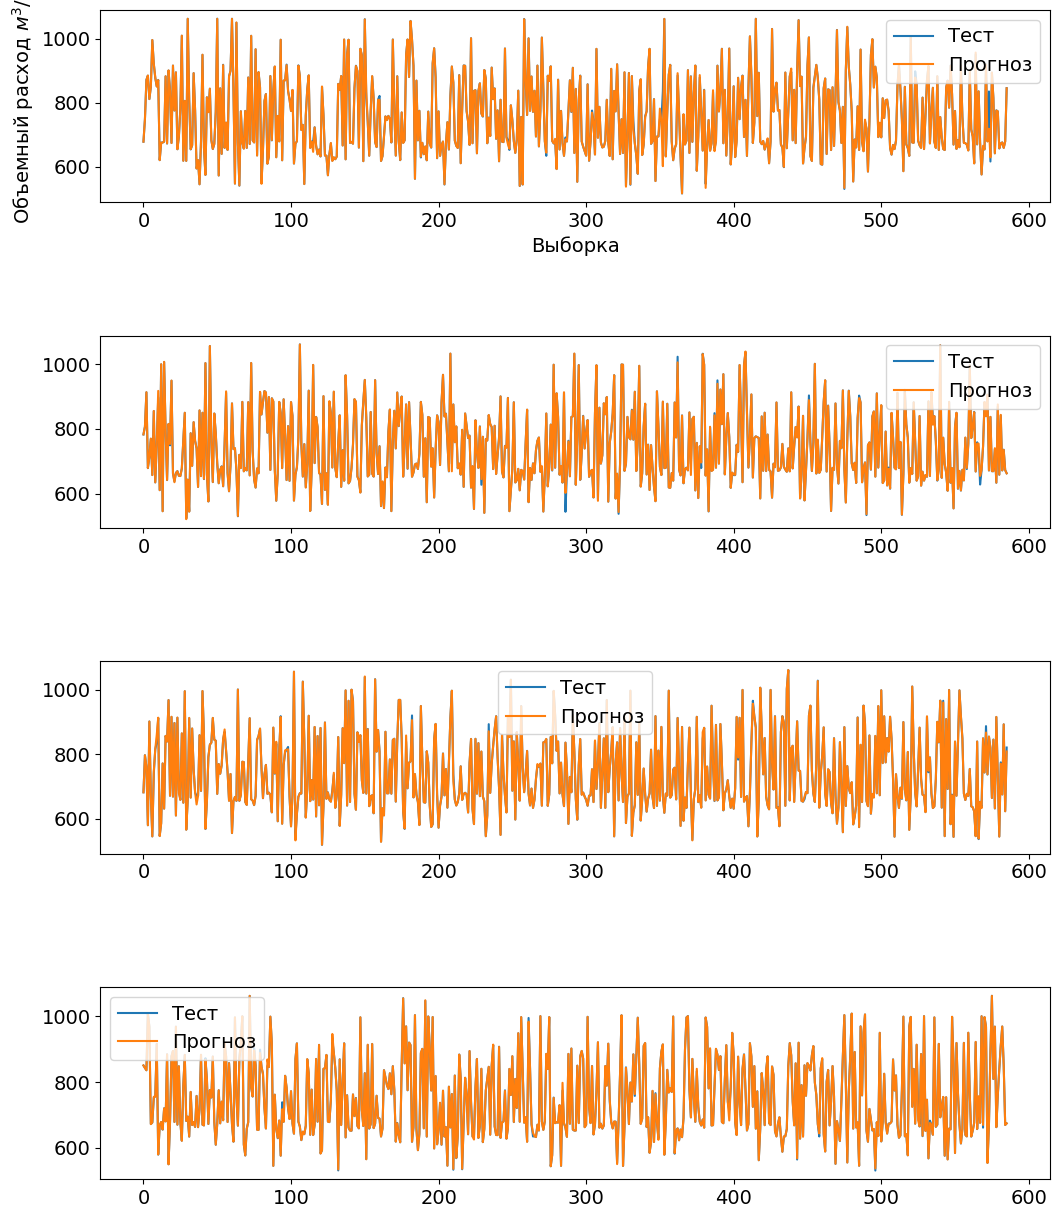

In [1371]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,14))
fig.tight_layout(pad=5.0)

level = 1.96
# pred_intr_upper

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_1.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n],
        label="Тест"
    )
    
    pred = mor_pl_1.predict(
         X.iloc[te])[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n],
        label="Прогноз",
        errorbar="ci"
    )
    
    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    print(interval)
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper, y.iloc[te].iloc[0]["Q2"]
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1.5102431896039548
single_pred 677.9912499999999 1086.641270357922 269.3412296420779
759.0605862292267 749.2604883962185 768.8606840622349
1.105817519538577
single_pred 781.835 957.2532873314242 606.4167126685759
743.6829989173234 734.4128137688965 752.9531840657503
0.5720729907623558
single_pred 682.3534683912857 692.3047815571813 672.4021552253901
744.4572850829952 734.7833911601857 754.1311790058047


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.729025786567828
single_pred 850.6158333333333 881.4048392488858 819.8268274177808
751.5571229098556 741.7230967311081 761.3911490886031


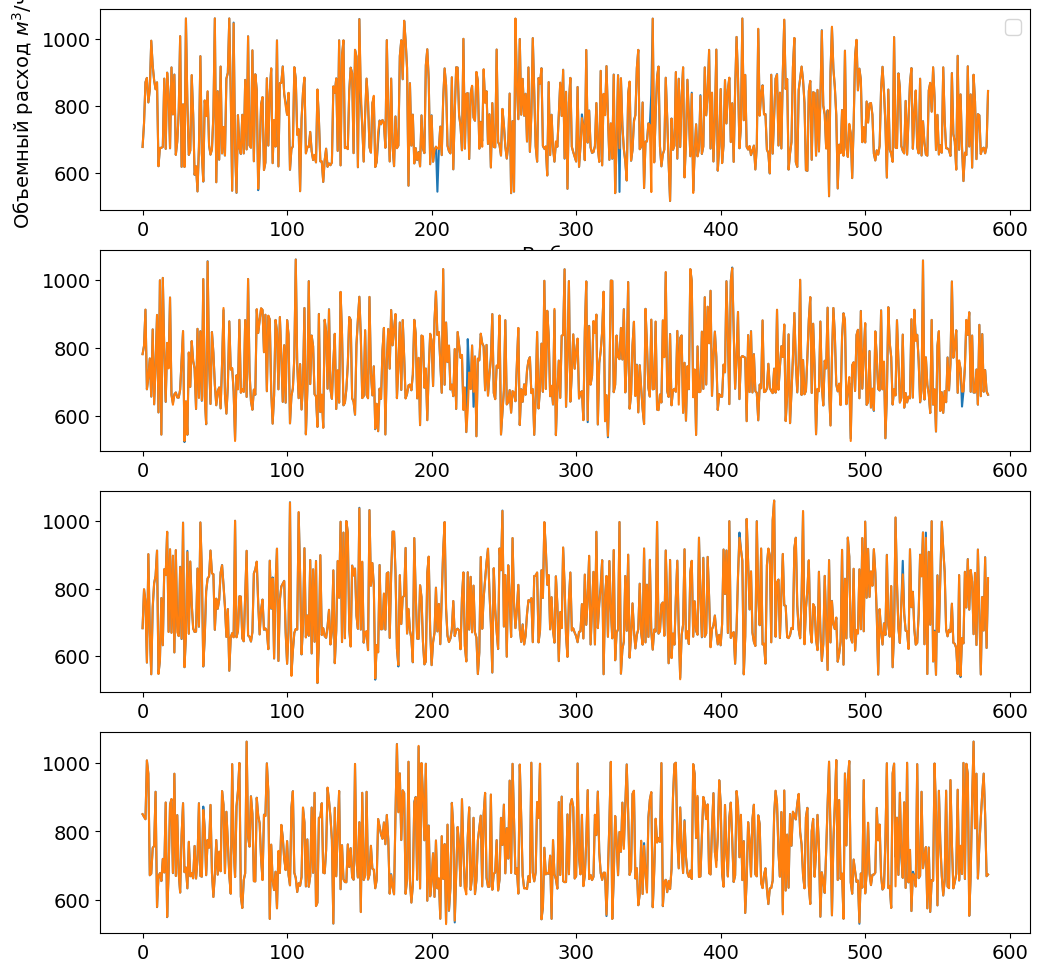

In [1372]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_2.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_pl_2.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


3.2348741682761313
single_pred 678.7314425336587 870.0826206318532 487.38026443546414
758.2286515301722 748.4330447113919 768.0242583489526


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.944041190872883
single_pred 780.596291637823 1031.9388202117404 529.2537630639056
744.4011795986743 735.1982858560073 753.6040733413413


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.535935337009526
single_pred 682.1703038642248 731.5906430387108 632.7499646897388
744.101692358077 734.476789219132 753.726595497022


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.8168900969182085
single_pred 849.4781152800798 925.812747982012 773.1434825781477
751.3203272589859 741.5289250916642 761.1117294263076


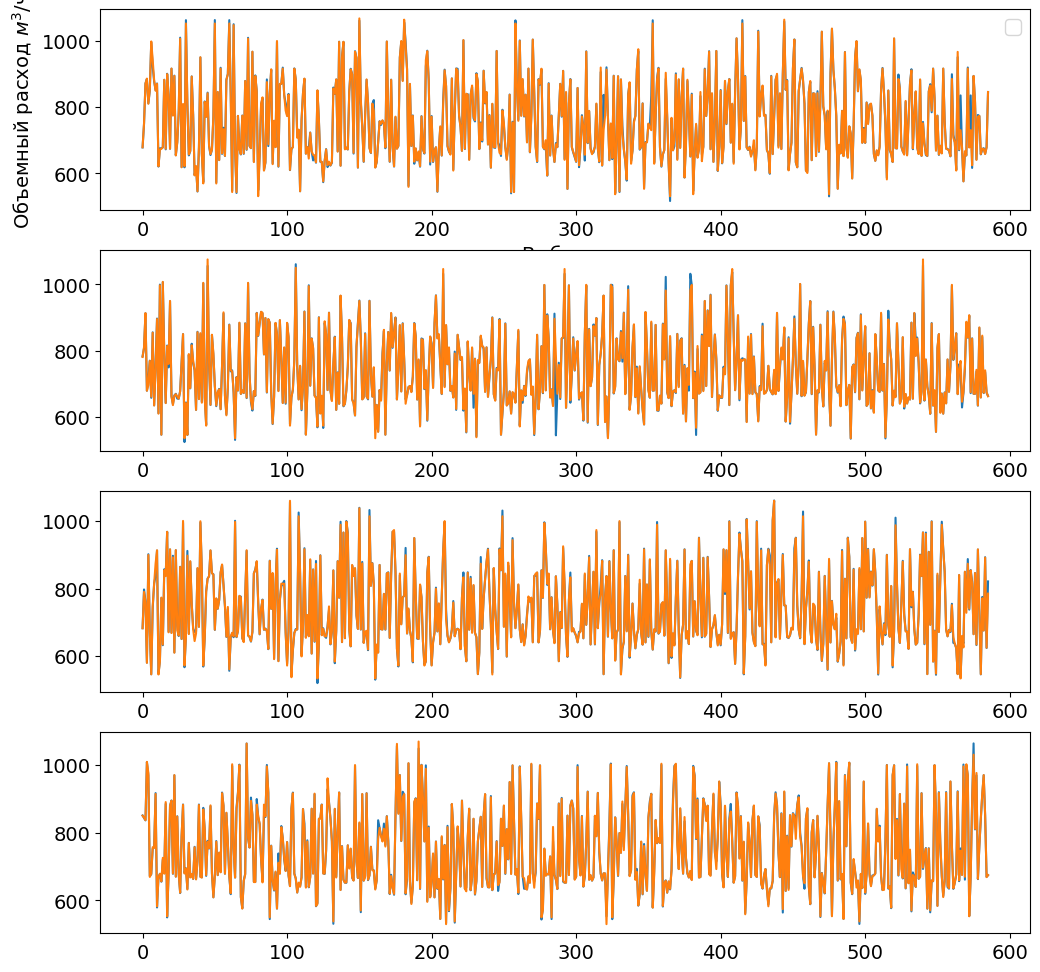

In [1373]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_gbr.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_gbr.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

# Sort shuffled by indexes to make reverse transform and show results of prediction

In [1374]:
tr0, te0 = ss_folds[0]

In [1375]:
tr0.shape

(5266,)

In [1376]:
te0_sorted = np.argsort(te0)

In [1377]:
mor_pl_2.fit(
    X.iloc[tr0],
    y.iloc[tr0]
)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_data',
                                                  StandardScaler(),
                                                  ['Nozzles_TOP',
                                                   'HE_TOP_mean']),
                                                 ('categorical_data',
                                                  OneHotEncoder(sparse=False),
                                                  ['pumps2'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor()))])

In [1378]:
mor_pl_2_toreverse = mor_pl_2.predict(X.iloc[te0])

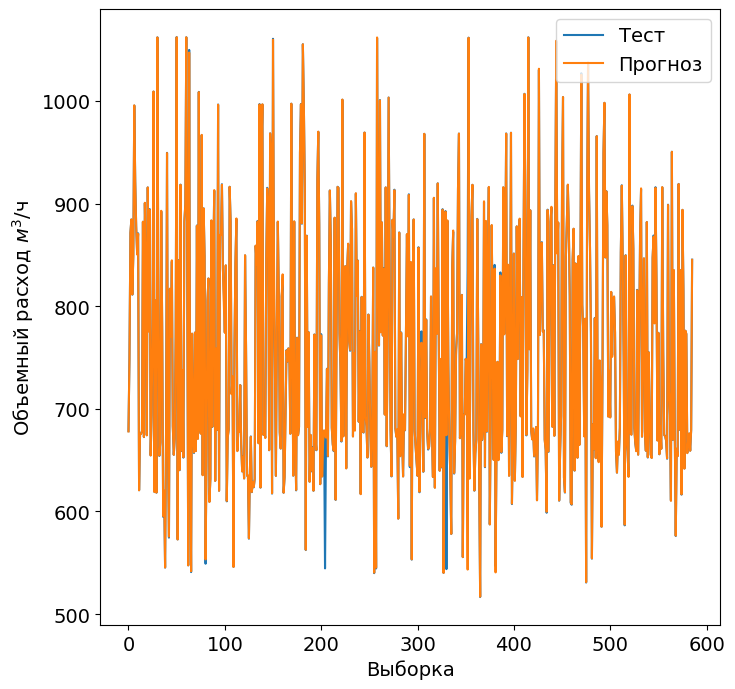

In [1379]:
fig, ax = plt.subplots(figsize=(8,8))

sns.lineplot(y.iloc[te0]["Q2"].to_numpy(), label="Тест")
sns.lineplot(mor_pl_2_toreverse[:, 0], label="Прогноз")

plt.xlabel("Выборка")
plt.ylabel("Объемный расход $м^3$/ч")

plt.legend()

In [1380]:
interval_toreverse = 1/( len(y.iloc[te0]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te0]["Q2"].to_numpy() - mor_pl_2_toreverse[:, 0] ) ** 2
        ) * level


In [1381]:
lower_toreverse = mor_pl_2_toreverse[:, 0] - interval_toreverse
upper_toreverse = mor_pl_2_toreverse[:, 0] + interval_toreverse

In [1382]:
lower_reversed = lower_toreverse[te0_sorted]
upper_reversed = upper_toreverse[te0_sorted]

In [1383]:
lower_toreverse, upper_toreverse

(array([271.98861767, 342.65945101, 465.58195101, 478.58361767,
        405.43403434, 443.32820101, 589.75111767, 515.26945101,
        471.25861767, 444.37070101, 464.47111767, 214.66111767,
        269.23945101, 269.46820101, 272.56861767, 476.34153434,
        266.55361767, 494.82320101, 431.34945101, 268.15611767,
        509.76195101, 369.36653434, 487.97375716, 248.52986767,
        288.02903434, 376.28275229, 603.2545582 , 212.93320101,
        399.50486767, 212.39236767, 655.93320101, 402.37153434,
        248.57236767, 261.43320101, 487.01653434, 370.29320101,
        189.48861767, 214.28528434, 139.38903434, 272.11445101,
        543.33653434, 253.91653434, 169.46486767, 411.13110384,
        364.15403434, 438.74820101, 277.09486767, 249.17403434,
        264.78195101, 368.84820101, 656.14820101, 166.72820101,
        438.50070101, 234.40611767, 512.34570101, 253.18445101,
        331.91986767, 246.81320101, 476.34153434, 493.71111767,
        656.10236767, 432.15861767, 141.

In [1384]:
mor_pl_2_Q2_reversed = mor_pl_2_toreverse[:, 0][te0_sorted]

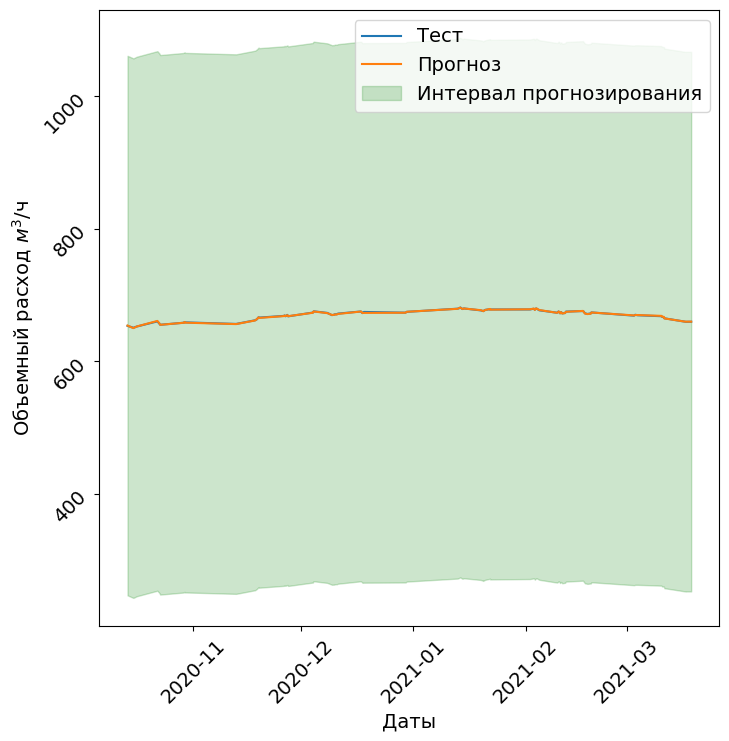

In [1385]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(8,8))

start = 0
shift = 87
ind = y.index[te0[te0_sorted]][start:shift]

sns.lineplot(
    x=ind, 
    y=y.iloc[te0[te0_sorted]]["Q2"][start:shift], 
    ax=ax, 
#     color="red",
    label="Тест"
    
)

sns.lineplot(
    x=ind, 
    y=mor_pl_2_Q2_reversed[start:shift], 
    ax=ax,
    label="Прогноз"
)

ax.fill_between(
    x=ind, 
    y1=lower_reversed[start:shift],
    y2=upper_reversed[start:shift],
    alpha=0.2,
    color="green",
    label="Интервал прогнозирования"
)

# ax.set_ylim(640,665)
ax.set_xlabel("Даты")
ax.set_ylabel("Объемный расход $м^3$/ч")
ax.tick_params(rotation=45)
ax.legend()

In [1386]:
y.iloc[te0[te0_sorted]]

Q2        P2
Timestamp                                
2020-10-13 22:00:00  653.598750  0.400000
2020-10-15 13:00:00  650.785417  0.400000
2020-10-16 11:00:00  652.557500  0.400000
2020-10-22 04:00:00  660.311667  0.400000
2020-10-22 17:00:00  656.996667  0.400000
...                         ...       ...
2023-06-06 21:00:00  847.860417  0.459866
2023-06-06 22:00:00  847.747500  0.459866
2023-06-07 03:00:00  843.502917  0.459937
2023-06-07 05:00:00  841.602917  0.459937
2023-06-08 22:00:00  810.993333  0.463261

[586 rows x 2 columns]

# The Decision Tree is the best model so far
# Saving it to a file

In [1387]:

# dump(mor_pl_2, "DT_Q2P2_v0.1_1h_freq.joblib")

# Now lets check how prediction accuracy may changes with feature elimination process

# Now lets check how prediction accuracy may changes with feature elimination process

In [1388]:
from sklearn.metrics import PredictionErrorDisplay

In [1389]:
mor_pl_2_whole = mor_pl_2.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1390]:
y_pred = mor_pl_2_whole.predict(X_test)

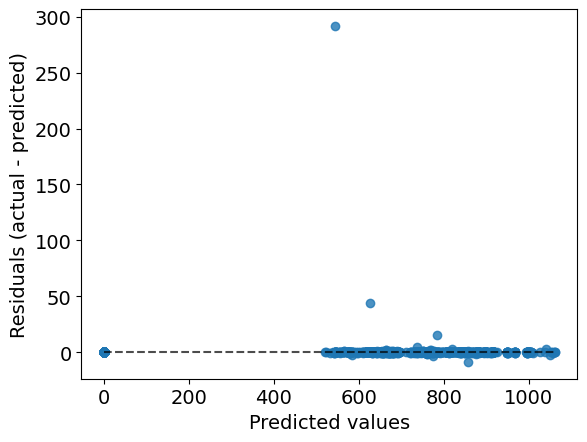

In [1391]:
PredictionErrorDisplay.from_estimator(
    mor_pl_2_whole, 
    X, 
    y
)

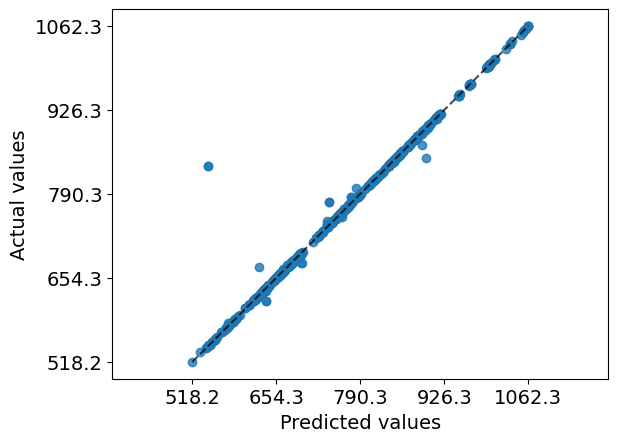

In [1392]:
PredictionErrorDisplay.from_predictions(
    y_true=y_test["Q2"], 
    y_pred=y_pred[:, 0],
    kind="actual_vs_predicted"
)

NormaltestResult(statistic=1.7445328886174374, pvalue=0.41800309410959235)

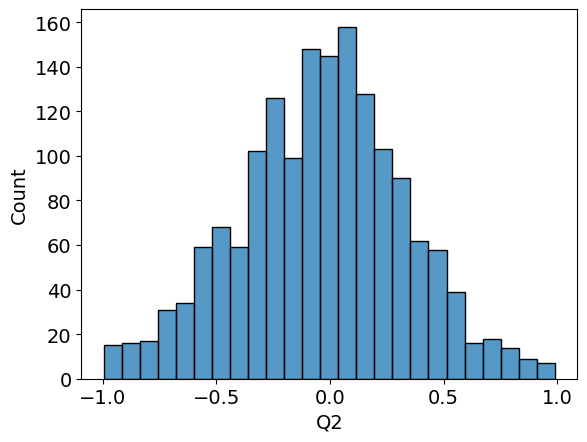

In [1393]:
residuals = y_test["Q2"] - y_pred[:, 0]
sns.histplot(residuals[(residuals < 1) & (residuals > -1)])
scipy.stats.normaltest(residuals[(residuals < 1) & (residuals > -1)])

# Fast undersampling of p234

In [1394]:
# df_stats_Q2_us = pd.concat(
#     [
#         df_stats_Q2.loc[df_stats_Q2[df_stats_Q2["pumps2"] == 234].sample(frac=0.2).index, :], 
#         df_stats_Q2.loc[df_stats_Q2[df_stats_Q2["pumps2"] != 234].index, :]
#     ]
# ).sample(frac=1)

In [1395]:
# df_stats_Q2_us

Q2        P2   Nozzles_TOP  HE_TOP_mean  pumps2
Timestamp                                                                   
2021-02-12 08:00:00  675.626250  0.404612      0.000000  5887.831459     134
2020-12-17 19:00:00  673.092917  0.401218      0.000000  3696.521744     234
2021-03-05 00:00:00  667.111250  0.405362      0.000000  6810.488180     234
2022-03-17 06:00:00  838.044583  0.370017   5337.704851  3675.095911     234
2020-11-17 18:00:00  664.174167  0.405413      0.000000  2400.731789     234
...                         ...       ...           ...          ...     ...
2023-05-11 11:00:00  763.000000  0.400000  14043.712471  3297.599506     123
2023-02-16 09:00:00  675.087083  0.470000  11945.361443  4260.226192     234
2022-12-14 11:00:00  679.468750  0.445117  10335.453391  2995.201478     124
2023-05-18 02:00:00  759.568333  0.400033  14317.240538  3484.633767     123
2021-12-02 10:00:00  868.665833  0.373293   3094.774702  2689.253986     234

[2448 rows x 5 columns]

In [1396]:
# X = df_stats_Q2_us.drop(["Q2", "P2"], axis=1)
# y = df_stats_Q2_us[["Q2", "P2"]]

In [1397]:
# X.shape, y.shape

((2448, 3), (2448, 2))

In [1398]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [1459]:
X_train

Nozzles_TOP   HE_TOP_mean  pumps2
Timestamp                                              
2020-12-18 01:00:00      0.000000   3737.227188     234
2021-03-11 00:00:00      0.000000   7034.368120     234
2020-11-26 07:00:00      0.000000   2821.354707     234
2023-01-11 14:00:00  10843.434087   3394.359761     234
2022-03-31 12:00:00   5873.038354   4038.120446     234
...                           ...           ...     ...
2021-10-05 23:00:00   1520.034544   1347.725001     234
2023-03-10 00:00:00  12277.502667   4521.214300     234
2021-05-04 23:00:00      0.000000  10494.330827     234
2021-04-27 20:00:00      0.000000   9897.317654     234
2022-03-30 21:00:00   5814.425197   3998.373234     234

[4096 rows x 3 columns]

In [1460]:
DT = tree.DecisionTreeRegressor().fit(ct.fit_transform(X_train), y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1461]:
DT.feature_importances_, ct.fit_transform(X_train).columns

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([8.49584396e-01, 1.11295441e-01, 5.45225042e-04, 0.00000000e+00,
        3.38191930e-02, 4.74378173e-03, 1.19635248e-05]),
 Index(['numerical_data__Nozzles_TOP', 'numerical_data__HE_TOP_mean',
        'categorical_data__pumps2_123', 'categorical_data__pumps2_124',
        'categorical_data__pumps2_134', 'categorical_data__pumps2_234',
        'categorical_data__pumps2_1234'],
       dtype='object'))

# Upload new data

In [1402]:
# df_new = pd.read_csv("archive/190923_200923_2nd_circuit.csv")
df_new = pd.read_csv("archive/050923_080923_2nd_circuit.csv")

In [1403]:
prep_csv = CsvRefactorer(df_new)

In [1404]:
ids = prep_csv.select_by_ids(prep_csv.ids)

In [1405]:
group = prep_csv.min_frac_groupby(30, *ids)

In [1406]:
df_new = prep_csv.concat_dfs(group)

In [1407]:
df_new = df_new.rename(columns=prep_csv.IDS_MAP)

<AxesSubplot: xlabel='Timestamp', ylabel='Q2'>

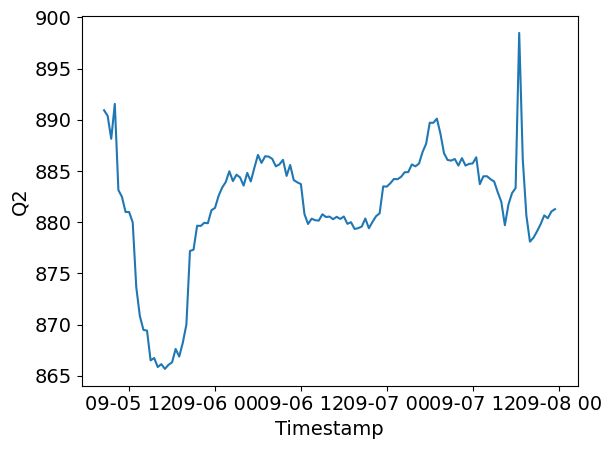

In [1408]:
sns.lineplot(df_new["Q2"])

In [1409]:
# df_new_to_test = df_new.loc[:, ["P2", "Q2", "p21", "p22", "p23", "p24"]]

In [1410]:
fe_new = FeatureEngineering(df_new)

In [1411]:
fe_new.df = fe_new.df.loc["2023-09-07":, ] 

In [1412]:
fe_new.filter_by_zscore(column="Q2")

Q2


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-07 00:00:00  39.284043  0.400000  42.293617  32.280851  35.030612   
2023-09-07 00:30:00  39.612903  0.400000  42.632258  32.603260  35.367347   
2023-09-07 01:00:00  39.846739  0.400000  42.870653  32.792473  35.579569   
2023-09-07 01:30:00  40.079570  0.400000  43.112903  33.051546  35.820213   
2023-09-07 02:00:00  40.351064  0.400000  43.396774  33.307071  36.089899   
2023-09-07 02:30:00  40.586956  0.400000  43.646236  33.548420  36.331579   
2023-09-07 03:00:00  40.784043  0.400000  43.835484  33.744330  36.536842   
2023-09-07 03:30:00  40.929294  0.400000  43.997802  33.845000  36.656250   
2023-09-07 04:00:00  41.000000  0.400000  44.094504  33.883872  36.702175   
2023-09-07 04:30:00  41.000000  0.400000  44.099998  33.881915  36.705208   
2023-09-07 05:00:00  41.125806  0.399375  44.196938  34.057143  36.866667   
2023-09-07 05:30:00  41.352942  0.398824  44.441380  34.317046  37.126436   
2023-09-07 06:00:00  41.560000  0.397143  44.659999  34.533333  37.333334   
2023-09-07 06:30:00  41.740000  0.397091  44.892223  34.605262  37.477273   
2023-09-07 07:00:00  43.175962  0.396607  48.274074  31.903333  36.284071   
2023-09-07 07:30:00  41.904546  0.398611  47.649533  28.258407  33.404425   
2023-09-07 08:00:00  40.027185  0.399118  45.798058  26.208824  31.338095   
2023-09-07 08:30:00  38.904000  0.399375  44.758416  25.103158  30.189691   
2023-09-07 09:00:00  39.875247  0.399143  46.479048  24.741237  30.321875   
2023-09-07 09:30:00  40.560215  0.399143  47.315958  24.938947  30.673913   
2023-09-07 10:00:00  40.870968  0.397447  47.657609  25.193617  30.961052   
2023-09-07 10:30:00  41.068816  0.397500  47.861291  25.373913  31.160870   
2023-09-07 11:00:00  41.241758  0.396727  48.010638  25.579570  31.364130   
2023-09-07 11:30:00  41.400001  0.396164  48.161290  25.770213  31.545745   
2023-09-07 12:00:00  41.494506  0.395376  48.213044  26.017172  31.744681   
2023-09-07 12:30:00  41.514130  0.394911  48.219792  26.060417  31.763725   
2023-09-07 13:00:00  41.628723  0.395556  48.396810  25.996808  31.785567   
2023-09-07 13:30:00  41.432632  0.395333  48.225806  25.632292  31.471134   
2023-09-07 14:00:00  41.148913  0.395100  47.929033  25.409574  31.209783   
2023-09-07 14:30:00  41.043010  0.395225  47.799999  25.485417  31.225263   
2023-09-07 15:00:00  41.168478  0.395300  47.855435  25.694737  31.418556   
2023-09-07 15:30:00  41.211957  0.396081  47.940207  25.692392  31.405494   
2023-09-07 16:00:00  41.293548  0.396667  48.000000  25.631251  31.387912   
2023-09-07 16:30:00  38.222609  0.399394  42.909483  25.777320  30.371568   
2023-09-07 17:00:00  34.955339  0.398889  38.466355  26.033684  29.330612   
2023-09-07 17:30:00  34.639361  0.398000  37.857609  26.797938  29.742857   
2023-09-07 18:00:00  35.151042  0.396230  38.293617  27.566667  30.425773   
2023-09-07 19:00:00  36.191579  0.395000  39.260417  28.889796  31.667677   
2023-09-07 19:30:00  36.717895  0.392885  39.800000  29.381053  32.192553   
2023-09-07 20:00:00  37.129474  0.390000  40.190425  29.883505  32.675000   
2023-09-07 20:30:00  37.654737  0.390000  40.687369  30.524742  33.287368   
2023-09-07 21:00:00  38.222917  0.390000  41.242105  31.206122  33.932292   
2023-09-07 21:30:00  38.855670  0.390000  41.845744  31.932291  34.645455   
2023-09-07 22:00:00  39.345162  0.390000  42.367369  32.329898  35.096809   
2023-09-07 22:30:00  39.658064  0.390000  42.724468  32.543877  35.342554   
2023-09-07 23:00:00  39.854839  0.390000  42.933334  32.701064  35.512500   
2023-09-07 23:30:00  40.093478  0.390000  43.158064  32.983000  35.787234   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-07 00:00:00  38.535185  35.274737  10.738793  1.940480  144.562220   
2023-09-07 00:30:

In [1413]:
fe_new.df = fe_new.df.rolling(6).mean().dropna()

In [1414]:
fe_new.df["pumps2"] = np.full(shape=len(fe_new.df), fill_value=234)

In [1415]:
fe_new.columns_averaging(columns=["p21", "p22", "p23", "p24"], omitbelow=50, feature_name="I2mean")

['p21', 'p22', 'p23', 'p24']


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-07 02:30:00  39.960212  0.400000  42.992074  32.930604  35.703203   
2023-09-07 03:00:00  40.210212  0.400000  43.249051  33.174517  35.954242   
2023-09-07 03:30:00  40.429611  0.400000  43.476642  33.381474  36.169059   
2023-09-07 04:00:00  40.621821  0.400000  43.680617  33.563373  36.356159   
2023-09-07 04:30:00  40.775226  0.400000  43.845133  33.701768  36.503659   
2023-09-07 05:00:00  40.904350  0.399896  43.978494  33.826780  36.633120   
2023-09-07 05:30:00  41.032014  0.399700  44.111018  33.954884  36.765596   
2023-09-07 06:00:00  41.161340  0.399224  44.248437  34.086385  36.898345   
2023-09-07 06:30:00  41.296458  0.398739  44.397507  34.213095  37.035182   
2023-09-07 07:00:00  41.659118  0.398173  45.094102  33.883005  36.965498   
2023-09-07 07:30:00  41.809876  0.397942  45.685691  32.945754  36.415368   
2023-09-07 08:00:00  41.626772  0.397899  45.952545  31.637701  35.493939   
2023-09-07 08:30:00  41.218615  0.397991  46.005384  30.102053  34.337815   
2023-09-07 09:00:00  40.937823  0.398324  46.308559  28.470037  33.169238   
2023-09-07 09:30:00  40.741192  0.398666  46.712514  26.858984  32.035345   
2023-09-07 10:00:00  40.357027  0.398806  46.609770  25.740698  31.148175   
2023-09-07 10:30:00  40.217739  0.398621  46.645063  25.259949  30.774249   
2023-09-07 11:00:00  40.420168  0.398222  47.013826  25.155074  30.778589   
2023-09-07 11:30:00  40.836168  0.397687  47.580972  25.266250  31.004598   
2023-09-07 12:00:00  41.106044  0.397060  47.869972  25.478905  31.241732   
2023-09-07 12:30:00  41.265030  0.396354  48.020611  25.665817  31.423367   
2023-09-07 13:00:00  41.391322  0.396039  48.143811  25.799682  31.560786   
2023-09-07 13:30:00  41.451958  0.395678  48.204563  25.842745  31.612497   
2023-09-07 14:00:00  41.436484  0.395407  48.190962  25.814413  31.586772   
2023-09-07 14:30:00  41.376985  0.395250  48.130747  25.766947  31.533359   
2023-09-07 15:00:00  41.322648  0.395237  48.071146  25.713208  31.479005   
2023-09-07 15:30:00  41.272285  0.395433  48.024548  25.651870  31.419300   
2023-09-07 16:00:00  41.216423  0.395618  47.958413  25.590944  31.353024   
2023-09-07 16:30:00  40.681419  0.396294  47.072360  25.615115  31.169763   
2023-09-07 17:00:00  39.649157  0.396926  45.495247  25.719133  30.856568   
2023-09-07 17:30:00  38.581882  0.397388  43.838182  25.937887  30.609500   
2023-09-07 18:00:00  37.578976  0.397543  42.244545  26.249875  30.444036   
2023-09-07 19:00:00  36.742246  0.397363  40.797913  26.782776  30.487733   
2023-09-07 19:30:00  35.979638  0.396733  39.431247  27.407743  30.621840   
2023-09-07 20:00:00  35.797448  0.395167  38.978071  28.092107  31.005745   
2023-09-07 20:30:00  36.247348  0.393686  39.348239  28.840617  31.665205   
2023-09-07 21:00:00  36.844607  0.392352  39.912322  29.575314  32.363444   
2023-09-07 21:30:00  37.462045  0.391314  40.504343  30.302918  33.066724   
2023-09-07 22:00:00  37.987642  0.390481  41.022169  30.876269  33.638246   
2023-09-07 22:30:00  38.477671  0.390000  41.509580  31.403406  34.163246   
2023-09-07 23:00:00  38.931898  0.390000  41.966731  31.872999  34.636163   
2023-09-07 23:30:00  39.338355  0.390000  42.378514  32.282709  35.052807   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-07 02:30:00  39.269386  35.944298  10.599660  1.118172  145.187984   
2023-09-07 03:00:00  39.535396  36.192893  10.538223  1.070422  145.401039   
2023-09-07 03:30:00  39.780041  36.407978  10.422740  1.070422  145.334258   
2023-09-07 04:00:00  39.990900  36.599686  10.273133  1.079046  145.343603   
2023-09-07 04:30:00  40.152884  36.747608  10.032457  0.927290  145.206803   
2023-09-07 05:00:00  40.272289  36.875683   9.743327  0.330438  144.934081   
2023-09-07 0

In [1416]:

# period = [("2023-09-19", "2023-09-20")]
period = [("2023-09-06", "2023-09-08")]

fe_new.make_time_onpower_feature(
#     time_periods=period, feature_name="HE1_TOP", start=df_stats["HE1_TOP"][-1]
    time_periods=period, feature_name="HE1_TOP", start=0
)

fe_new.make_time_onpower_feature(
#     time_periods=period, feature_name="HE2_TOP", start=df_stats["HE2_TOP"][-1]
    time_periods=period, feature_name="HE2_TOP", start=0
)

fe_new.make_time_onpower_feature(
#     time_periods=period, feature_name="HE3_TOP", start= df_stats["HE3_TOP"][-1]
    time_periods=period, feature_name="HE3_TOP", start=0
)

fe_new.df["HE4_TOP"] = np.zeros(len(fe_new.df))


fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE5_TOP", start=df_stats["HE5_TOP"][-1]
)

[ 1.14285714  2.28571429  3.42857143  4.57142857  5.71428571  6.85714286
  8.          9.14285714 10.28571429 11.42857143 12.57142857 13.71428571
 14.85714286 16.         17.14285714 18.28571429 19.42857143 20.57142857
 21.71428571 22.85714286 24.         25.14285714 26.28571429 27.42857143
 28.57142857 29.71428571 30.85714286 32.         33.14285714 34.28571429
 35.42857143 36.57142857 37.71428571 38.85714286 40.         41.14285714
 42.28571429 43.42857143 44.57142857 45.71428571 46.85714286 48.        ] 42 42
[ 1.14285714  2.28571429  3.42857143  4.57142857  5.71428571  6.85714286
  8.          9.14285714 10.28571429 11.42857143 12.57142857 13.71428571
 14.85714286 16.         17.14285714 18.28571429 19.42857143 20.57142857
 21.71428571 22.85714286 24.         25.14285714 26.28571429 27.42857143
 28.57142857 29.71428571 30.85714286 32.         33.14285714 34.28571429
 35.42857143 36.57142857 37.71428571 38.85714286 40.         41.14285714
 42.28571429 43.42857143 44.57142857 45.7142

T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-07 02:30:00  39.960212  0.400000  42.992074  32.930604  35.703203   
2023-09-07 03:00:00  40.210212  0.400000  43.249051  33.174517  35.954242   
2023-09-07 03:30:00  40.429611  0.400000  43.476642  33.381474  36.169059   
2023-09-07 04:00:00  40.621821  0.400000  43.680617  33.563373  36.356159   
2023-09-07 04:30:00  40.775226  0.400000  43.845133  33.701768  36.503659   
2023-09-07 05:00:00  40.904350  0.399896  43.978494  33.826780  36.633120   
2023-09-07 05:30:00  41.032014  0.399700  44.111018  33.954884  36.765596   
2023-09-07 06:00:00  41.161340  0.399224  44.248437  34.086385  36.898345   
2023-09-07 06:30:00  41.296458  0.398739  44.397507  34.213095  37.035182   
2023-09-07 07:00:00  41.659118  0.398173  45.094102  33.883005  36.965498   
2023-09-07 07:30:00  41.809876  0.397942  45.685691  32.945754  36.415368   
2023-09-07 08:00:00  41.626772  0.397899  45.952545  31.637701  35.493939   
2023-09-07 08:30:00  41.218615  0.397991  46.005384  30.102053  34.337815   
2023-09-07 09:00:00  40.937823  0.398324  46.308559  28.470037  33.169238   
2023-09-07 09:30:00  40.741192  0.398666  46.712514  26.858984  32.035345   
2023-09-07 10:00:00  40.357027  0.398806  46.609770  25.740698  31.148175   
2023-09-07 10:30:00  40.217739  0.398621  46.645063  25.259949  30.774249   
2023-09-07 11:00:00  40.420168  0.398222  47.013826  25.155074  30.778589   
2023-09-07 11:30:00  40.836168  0.397687  47.580972  25.266250  31.004598   
2023-09-07 12:00:00  41.106044  0.397060  47.869972  25.478905  31.241732   
2023-09-07 12:30:00  41.265030  0.396354  48.020611  25.665817  31.423367   
2023-09-07 13:00:00  41.391322  0.396039  48.143811  25.799682  31.560786   
2023-09-07 13:30:00  41.451958  0.395678  48.204563  25.842745  31.612497   
2023-09-07 14:00:00  41.436484  0.395407  48.190962  25.814413  31.586772   
2023-09-07 14:30:00  41.376985  0.395250  48.130747  25.766947  31.533359   
2023-09-07 15:00:00  41.322648  0.395237  48.071146  25.713208  31.479005   
2023-09-07 15:30:00  41.272285  0.395433  48.024548  25.651870  31.419300   
2023-09-07 16:00:00  41.216423  0.395618  47.958413  25.590944  31.353024   
2023-09-07 16:30:00  40.681419  0.396294  47.072360  25.615115  31.169763   
2023-09-07 17:00:00  39.649157  0.396926  45.495247  25.719133  30.856568   
2023-09-07 17:30:00  38.581882  0.397388  43.838182  25.937887  30.609500   
2023-09-07 18:00:00  37.578976  0.397543  42.244545  26.249875  30.444036   
2023-09-07 19:00:00  36.742246  0.397363  40.797913  26.782776  30.487733   
2023-09-07 19:30:00  35.979638  0.396733  39.431247  27.407743  30.621840   
2023-09-07 20:00:00  35.797448  0.395167  38.978071  28.092107  31.005745   
2023-09-07 20:30:00  36.247348  0.393686  39.348239  28.840617  31.665205   
2023-09-07 21:00:00  36.844607  0.392352  39.912322  29.575314  32.363444   
2023-09-07 21:30:00  37.462045  0.391314  40.504343  30.302918  33.066724   
2023-09-07 22:00:00  37.987642  0.390481  41.022169  30.876269  33.638246   
2023-09-07 22:30:00  38.477671  0.390000  41.509580  31.403406  34.163246   
2023-09-07 23:00:00  38.931898  0.390000  41.966731  31.872999  34.636163   
2023-09-07 23:30:00  39.338355  0.390000  42.378514  32.282709  35.052807   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-07 02:30:00  39.269386  35.944298  10.599660  1.118172  145.187984   
2023-09-07 03:00:00  39.535396  36.192893  10.538223  1.070422  145.401039   
2023-09-07 03:30:00  39.780041  36.407978  10.422740  1.070422  145.334258   
2023-09-07 04:00:00  39.990900  36.599686  10.273133  1.079046  145.343603   
2023-09-07 04:30:00  40.152884  36.747608  10.032457  0.927290  145.206803   
2023-09-07 05:00:00  40.272289  36.875683   9.743327  0.330438  144.934081   
2023-09-07 0

In [1417]:
fe_new.make_time_onpower_feature(
#     time_periods=period, feature_name="Nozzles_TOP", start=df_stats["Nozzles_TOP"][-1]
    time_periods=period, feature_name="Nozzles_TOP", start=100
)

[101.14285714 102.28571429 103.42857143 104.57142857 105.71428571
 106.85714286 108.         109.14285714 110.28571429 111.42857143
 112.57142857 113.71428571 114.85714286 116.         117.14285714
 118.28571429 119.42857143 120.57142857 121.71428571 122.85714286
 124.         125.14285714 126.28571429 127.42857143 128.57142857
 129.71428571 130.85714286 132.         133.14285714 134.28571429
 135.42857143 136.57142857 137.71428571 138.85714286 140.
 141.14285714 142.28571429 143.42857143 144.57142857 145.71428571
 146.85714286 148.        ] 42 42


T1aHE        P2      T1bHE      T2bHE      T2aHE  \
Timestamp                                                                   
2023-09-07 02:30:00  39.960212  0.400000  42.992074  32.930604  35.703203   
2023-09-07 03:00:00  40.210212  0.400000  43.249051  33.174517  35.954242   
2023-09-07 03:30:00  40.429611  0.400000  43.476642  33.381474  36.169059   
2023-09-07 04:00:00  40.621821  0.400000  43.680617  33.563373  36.356159   
2023-09-07 04:30:00  40.775226  0.400000  43.845133  33.701768  36.503659   
2023-09-07 05:00:00  40.904350  0.399896  43.978494  33.826780  36.633120   
2023-09-07 05:30:00  41.032014  0.399700  44.111018  33.954884  36.765596   
2023-09-07 06:00:00  41.161340  0.399224  44.248437  34.086385  36.898345   
2023-09-07 06:30:00  41.296458  0.398739  44.397507  34.213095  37.035182   
2023-09-07 07:00:00  41.659118  0.398173  45.094102  33.883005  36.965498   
2023-09-07 07:30:00  41.809876  0.397942  45.685691  32.945754  36.415368   
2023-09-07 08:00:00  41.626772  0.397899  45.952545  31.637701  35.493939   
2023-09-07 08:30:00  41.218615  0.397991  46.005384  30.102053  34.337815   
2023-09-07 09:00:00  40.937823  0.398324  46.308559  28.470037  33.169238   
2023-09-07 09:30:00  40.741192  0.398666  46.712514  26.858984  32.035345   
2023-09-07 10:00:00  40.357027  0.398806  46.609770  25.740698  31.148175   
2023-09-07 10:30:00  40.217739  0.398621  46.645063  25.259949  30.774249   
2023-09-07 11:00:00  40.420168  0.398222  47.013826  25.155074  30.778589   
2023-09-07 11:30:00  40.836168  0.397687  47.580972  25.266250  31.004598   
2023-09-07 12:00:00  41.106044  0.397060  47.869972  25.478905  31.241732   
2023-09-07 12:30:00  41.265030  0.396354  48.020611  25.665817  31.423367   
2023-09-07 13:00:00  41.391322  0.396039  48.143811  25.799682  31.560786   
2023-09-07 13:30:00  41.451958  0.395678  48.204563  25.842745  31.612497   
2023-09-07 14:00:00  41.436484  0.395407  48.190962  25.814413  31.586772   
2023-09-07 14:30:00  41.376985  0.395250  48.130747  25.766947  31.533359   
2023-09-07 15:00:00  41.322648  0.395237  48.071146  25.713208  31.479005   
2023-09-07 15:30:00  41.272285  0.395433  48.024548  25.651870  31.419300   
2023-09-07 16:00:00  41.216423  0.395618  47.958413  25.590944  31.353024   
2023-09-07 16:30:00  40.681419  0.396294  47.072360  25.615115  31.169763   
2023-09-07 17:00:00  39.649157  0.396926  45.495247  25.719133  30.856568   
2023-09-07 17:30:00  38.581882  0.397388  43.838182  25.937887  30.609500   
2023-09-07 18:00:00  37.578976  0.397543  42.244545  26.249875  30.444036   
2023-09-07 19:00:00  36.742246  0.397363  40.797913  26.782776  30.487733   
2023-09-07 19:30:00  35.979638  0.396733  39.431247  27.407743  30.621840   
2023-09-07 20:00:00  35.797448  0.395167  38.978071  28.092107  31.005745   
2023-09-07 20:30:00  36.247348  0.393686  39.348239  28.840617  31.665205   
2023-09-07 21:00:00  36.844607  0.392352  39.912322  29.575314  32.363444   
2023-09-07 21:30:00  37.462045  0.391314  40.504343  30.302918  33.066724   
2023-09-07 22:00:00  37.987642  0.390481  41.022169  30.876269  33.638246   
2023-09-07 22:30:00  38.477671  0.390000  41.509580  31.403406  34.163246   
2023-09-07 23:00:00  38.931898  0.390000  41.966731  31.872999  34.636163   
2023-09-07 23:30:00  39.338355  0.390000  42.378514  32.282709  35.052807   

                      Treactor     T2aHE1       Tair       p21         p22  \
Timestamp                                                                    
2023-09-07 02:30:00  39.269386  35.944298  10.599660  1.118172  145.187984   
2023-09-07 03:00:00  39.535396  36.192893  10.538223  1.070422  145.401039   
2023-09-07 03:30:00  39.780041  36.407978  10.422740  1.070422  145.334258   
2023-09-07 04:00:00  39.990900  36.599686  10.273133  1.079046  145.343603   
2023-09-07 04:30:00  40.152884  36.747608  10.032457  0.927290  145.206803   
2023-09-07 05:00:00  40.272289  36.875683   9.743327  0.330438  144.934081   
2023-09-07 0

In [1418]:
fe_new.df["HE1_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE2_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE3_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE4_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE5_status"] = np.zeros(len(fe_new.df))

In [1419]:
fe_new.df.loc[:, "HE1_status"][fe_new.df.loc[:, "HE1_TOP"] != 0] = 1

fe_new.df.loc[:, "HE2_status"][fe_new.df.loc[:, "HE2_TOP"] != 0] = 1

fe_new.df.loc[:, "HE3_status"][fe_new.df.loc[:, "HE3_TOP"] != 0] = 1

fe_new.df.loc[:, "HE4_status"][fe_new.df.loc[:, "HE4_TOP"] != 0] = 1

fe_new.df.loc[:, "HE5_status"][fe_new.df.loc[:, "HE5_TOP"] != 0] = 1

/tmp/ipykernel_7675/1130005420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE1_status"][fe_new.df.loc[:, "HE1_TOP"] != 0] = 1
/tmp/ipykernel_7675/1130005420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE2_status"][fe_new.df.loc[:, "HE2_TOP"] != 0] = 1
/tmp/ipykernel_7675/1130005420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE3_status"][fe_new.df.loc[:, "HE3

In [1420]:
fe_new.df["HE_TOP_mean_nums"] = fe_new.df.loc[:, ["HE1_TOP", "HE2_TOP", "HE3_TOP", "HE4_TOP", "HE5_TOP"]].mean(axis=1) / fe.df.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)

In [1421]:
fe_new.df["HE_TOP_mean"] = fe_new.df.loc[:, ["HE1_TOP", "HE2_TOP", "HE3_TOP", "HE4_TOP", "HE5_TOP"]].mean(axis=1)

In [1422]:
fe_new.df["HEs_num"] = fe_new.df[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)

In [1423]:
df_new_to_test = fe_new.df.loc[
    :, 
    selection_cols_Q2
]

In [1424]:
df_new_to_test = df_new_to_test.drop(["Q2", "P2"], axis=1) 

In [1425]:
df_new_to_test.mean(), df_new[["Q2", "P2"]].mean()

(Nozzles_TOP    124.571429
 HE_TOP_mean    216.457143
 pumps2         234.000000
 dtype: float64,
 Q2    881.615123
 P2      0.398608
 dtype: float64)

In [1426]:
df_new_to_test_aver = df_new_to_test.mean(axis=0)

In [1427]:
df_new_to_test_aver = pd.DataFrame(data=df_new_to_test_aver.to_numpy().reshape(1,-1), index=[0], columns=df_new_to_test_aver.index)

In [1462]:
inp = ct.transform(df_new_to_test_aver)

In [1463]:
inp.columns

Index(['numerical_data__Nozzles_TOP', 'numerical_data__HE_TOP_mean',
       'categorical_data__pumps2_123', 'categorical_data__pumps2_124',
       'categorical_data__pumps2_134', 'categorical_data__pumps2_234',
       'categorical_data__pumps2_1234'],
      dtype='object')

In [1464]:
DT.predict(inp)

array([[1.04720504e+03, 3.62475153e-01]])

In [1465]:
DT.predict(inp)[0] / df_new[["Q2", "P2"]].mean()

Q2    1.187826
P2    0.909351
dtype: float64

In [1471]:
d = {
        "Nozzles_TOP" : 500,
#         "I2mean" : 140,
        "pumps2" : 234,
        "HE_TOP_mean" : 5000,
#         "HEs_num": 4,
    
}

In [1472]:
inp2 = pd.DataFrame(
    d,
    index=[0]
)

In [1473]:
inp2

Nozzles_TOP  pumps2  HE_TOP_mean
0          500     234         5000

In [1474]:
inp2 = ct.transform(inp2)

In [1475]:
DT.predict(inp2)

array([[9.50907652e+02, 3.46121749e-01]])